In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))

# Study of Nonlocal Misfit Scalar Regularization Parameter $\lambda$ System

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter 
    <a href="https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/">extensions</a>.
</div>

In [1]:
# Packages
import numpy as np
import pandas as pd
import scipy.sparse as sparse

import numba
from   numba import jit

import time
import itertools

#import imageio
#from   skimage.transform import resize
from   skimage.metrics   import structural_similarity as ssim
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
from   matplotlib    import ticker
from matplotlib.gridspec import GridSpec

import skimage.io    as io
import skimage.color as color
from   skimage              import data_dir
from   skimage.transform    import resize
from   mpl_toolkits.mplot3d import Axes3D
from   matplotlib           import cm
from   matplotlib.ticker    import LinearLocator, FormatStrFormatter, MultipleLocator

<div class="alert alert-block alert-success">
We study the following scalar nonlocal bilevel problem:
\begin{align*}
        &\min \dfrac{1}{2} \|u-u^T\|^2_{0,\Omega} =: f(\lambda)
    \\
    \text{subject to}\qquad
    \\
        & (u,\phi)_V + \big( \lambda(u-f), \phi \big) = 0, &\forall \phi \in V.
\end{align*}
</div>

$\DeclareMathOperator{\AK}{\mathrm{AK}_\sigma}$
The nonlocal product $(u,\phi)_V$ is defined as
\begin{align}
    (u,\phi)_V = ( u \AK \mathbb{1} - \AK u, \phi )_{L^2(\Omega)}.
\end{align}
Here $\AK$ represents the unnormalised _extended Gaussian ANOVA kernel_, which in turn is given by:
\begin{align}
    \AK u (x) = \sum_{\ell=1}^L \frac{1}{L} \int_\Omega u(y)\, e^{-\sigma^{-2} \big\| \mathcal{W}_\ell [f](x) - \mathcal{W}_\ell [f](y) \big\|^2}  \mathrm{d}y,
\end{align}
where $\sigma$ is a shape parameter, $L$ is the number of kernels to combine, and $\mathcal{W}_\ell = \{ w_1^\ell, w_2^\ell, w_3^\ell \} \in \{ 1, \dots, d \}^3$ are patches of features, so that $\mathcal{W}_\ell [f](x)$ and $\mathcal{W}_\ell [f](y)$ are the data points restricted to the corresponding features. 
The normalised version of this kernel is given by the quotient $\AK u / \AK \mathbb{1}$. In this notebook we will explore the use of the nonequispaced spherical transform to compute $\AK u$ and its use for image denoising tasks.
We have a weighted sum of multiple kernels, where every kernel relies on not more than 3 features and, thus, we can apply the NFFT-based fast summation approach and use the [`fastadj`](https://github.com/dominikalfke/FastAdjacency) package by Dominik Alfke to speed up the kernel-vector multiplication.

The nonequispaced Gauss transform computes, for a given $d$-dimensional *point cloud* of $n$ points $x_i \in \mathbb{R}^d$, $i=1,\ldots,n$, the action of the operator
\begin{align}
A = (a_{ij})_{i,j=1}^n \in \mathbb{R}^{n \times n}, \qquad A_{ij} = \exp\left(\frac{-\|x_i - x_j\|^2}{\sigma^2}\right).
\end{align}

We will apply the extended Gaussian ANOVA toolkit [`nfft4anova`](https://github.com/wagnertheresa/NFFT4ANOVA) by Theresa Wagner to determine $L$ and the feature patches $\mathcal{W}_\ell [f]$.

In [2]:
import fastadj

In [3]:
# Local packages
from sys import path
path.insert(0, 'NFFT4ANOVA/nfft4anova')
from nfft_kernel_ridge import NFFTKernelRidge        # extended Gaussian ANOVA computation toolbox

In [4]:
# Aliases
from scipy.sparse.linalg import LinearOperator, minres
from scipy.sparse        import csr_matrix
from scipy.optimize      import Bounds, minimize
from scipy.stats         import describe
from pandas              import DataFrame

# Numpy aliases
from numpy import linspace, pad, broadcast_to
from numpy.lib.stride_tricks import sliding_window_view

from numpy        import asarray, logspace, sqrt, clip, around, array, square, ravel, empty, meshgrid
from numpy        import multiply, add, reciprocal, subtract, empty_like, stack, arange
from numpy        import zeros, append, diagflat, triu, tril, logical_and, where, ones, minimum, allclose
from numpy.linalg import inv, norm
from numpy.random import default_rng
lsolver     = sparse.linalg.lgmres

In [5]:
# More alisases
from sklearn.metrics.pairwise import rbf_kernel
from skimage                  import data
from skimage.transform        import rescale
from imageio                  import imwrite, imread

from IPython.display          import Latex

from scipy.sparse.linalg      import eigsh, eigs
from scipy.linalg             import eigvals, eigvalsh, svdvals
from scipy.spatial.distance   import cdist
from scipy.optimize           import curve_fit
from numpy.lib.stride_tricks  import as_strided

<div class="alert alert-block alert-info">
We load one image from the data set.
</div>

In [6]:
images = { 1:'lena',  2:'baboon', 3:'fprint3', 4:'cameraman', 5:'monarch', 
           6:'sails', 7:'fruits', 8:'peppers', 9:'mountain', 10:'texmos3',
          11:'zebra'}

In [7]:
nume = 5                       # Selected image

Once an image is selected, a new sub-data set is created with **five** new noisy images stored in list `noisy`.

In [8]:
image = data.cell()

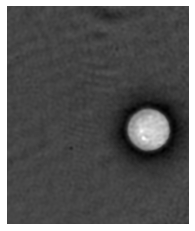

In [9]:
plt.imshow(image, cmap='gray');    plt.axis('off');    plt.show()

We will use a specific image size that is tractable and collect set-up time and operator time:

In [11]:
Scales = np.logspace(-2,0.0,10)

Setup matrices and operators (set $\mathrm{diag}(\Gamma) = 0$):

In [12]:
# Scale image
img = rescale(image, 1.0, anti_aliasing=True)
img = asarray(img).astype(float, copy = False)
N,M = img.shape
nm  = img.size
print(N,M,nm)

# Create noisy sample
## Fix seed
rng = default_rng(10)
σ_i = logspace(1,3,5)[3]
f = rng.normal(0, sqrt(σ_i), img.shape);    f += img;    clip(f, 0.0, 255.0, out=f)
print('{0:10} -> {1}'.format( around(σ_i,2), around(ssim(img, f, data_range=f.max()-f.min() ),2)  ))

# Patch radius
ρ = 5


'''
    Kernel Setup
'''
def SSIM(img,u, N,M):  return ssim(img, u.reshape(N,M), data_range=u.max()-u.min())


clf = NFFTKernelRidge(sigma=1.0, norm = None, setup = 'default')
ρ̂    = 2*ρ+1

"""Patches"""
Fᵖᵃᵈ = pad(f, ρ, mode='constant')
X = sliding_window_view(Fᵖᵃᵈ, (ρ̂,ρ̂)).reshape(nm, ρ̂**2)

'''Build windows'''
window_scheme = 'mis'
# determine windows of features by their mis
if window_scheme == 'mis':
    res_idx = clf.make_mi_scores(X, around(f).astype(int).ravel())
    windows = clf.get_mis_windows(res_idx)

# windows are built following the feature indices in ascending order
elif window_scheme == 'consec':
    d    = X.shape[1]
    windows = [list(range((l*3),(l*3) + 3)) for l in range(d//3)]

    # if |d| is not divisible by 3, the last window contains only 1 or 2 indices
    if d%3 != 0:    windows.append( [l for l in range(d - d%3, d)] )

# use predefined list of windows of features
elif window_scheme == None:
    windows = pre_list

num_windows = len(windows)

'''Weights'''
# Select weight creation mode
weight_scheme = 'equally weighted'

# Compute kernel weights: equal weights that sup up to 1 or no weighting:
k_weight = 1.0/num_windows if weight_scheme == 'equally weighted' else 1.0

# Store weights efficiently as a view
weights = broadcast_to(k_weight, (num_windows, ))


'''Kernel as abstract object'''
def W(σ, n = 64, m = 8, p = 8, Other_Setup = None):
    '''
    Set up the subkernel matrices that constitute the extended Gaussian ANOVA kernel

    Note
    ----
    Using the NFFT-approach, the kernel matrices are never computed explicitly.

    Parameters
    ----------
    X : ndarray
        The training data matrix.
    σ : float
        Shape of the kernel.
    n : even int
        The NFFT expansion degree.
    m : int ≤ max(N,M)
        Window cutoff.
    p : int
        Smoothness of the window function.

    Returns
    -------
    SubKernels : list of fastadj.AdjacencyMatrix
        Subkernel matrices for each window of features according to the selected window scheme.
    '''

    # Bound on window cutoff [Lemma 3.4]
    if n < max([4*m,12]):
        print('Changing n = {} to {}'.format(n, max([4*m,12])))
        n = max([4*m,12])

    # Setup approximation parameters
    NFFT_setup = fastadj.AccuracySetup(n,m,p,0,0)   if Other_Setup is None else   Other_Setup

    # Set diagonal → 1, since FastAdjacency package is targeted at graph Laplacian with zeros at the diagonal
    # but we need 1 at the diagonal
    return [fastadj.AdjacencyMatrix(X[:,windows[l]], σ, NFFT_setup, 0.0) for l in range(num_windows)]
σ = 30.0


SubKernels = W(σ, Other_Setup = 'default')


def AK(u):
    """
    Approximate the matrix-vector product AK*u, where AK = w_1*K_1 + w_2*K_2 + ... + w_L*K_L.

    Note
    ----
    Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
    Any other variable needed has to be global, so that they can still be used within this function

    Parameters
    ----------
    u : ndarray
        The vector, whose product AK*u with the matrix AK shall be approximated.

    Returns
    -------
    AKu : ndarray
        The approximated matrix-vector product AK*u.
    """

    # Apply matrix-vector multiplication
    subKernelProducts = asarray([SubKernels[l].apply(u) for l in range(num_windows)])

    # Multiply each subKernel by its weight and collect into a sum
    AKu = weights.dot(subKernelProducts)

    return AKu

Kernel = LinearOperator(shape = (nm,nm), matvec = (AK), rmatvec = (AK))


'''Kernel as an explicit object'''
def Full_W(σ):
    B = np.zeros([nm,nm])
    for l in range(num_windows):
        B += rbf_kernel(X[:,windows[l]], gamma = (σ**-2) )
    B *= k_weight
    return B

if nm < 8670:
    ANOVA = Full_W(σ)

# Define rhs
u = f.ravel()/nm

66 55 3630
    316.23 -> 0.29


---

In [13]:
# Set weight
μ = 2e-2

In [14]:
λ = 10.0
η = Kernel( ones(nm) )

In [15]:
def matvec(v):       return μ * (η * v - Kernel(v)) + λ * v
A = LinearOperator((nm,nm), dtype=np.float64, matvec=matvec, rmatvec=matvec)

In [16]:
# Previous lower bound:   σᴸ = abs(f.max() - f.min())/(710**0.5)
fᵂ = [norm(X[:, windows[l]].max(0) - X[:, windows[l]].min(0)) for l in range(num_windows)]
σᴸ = max(fᵂ)/(710**0.5)
# Previous upper bound:   σᵁ = abs(f.max() - f.min()) * 1e-1
σᵁ = min(fᵂ) * 1e+5

In [17]:
print('Suggested range for σ: {}'.format([σᴸ, σᵁ]))

Suggested range for σ: [16.27347274188335, 25035068.717526518]


In [18]:
eigsh(μ*(np.diag(η) - ANOVA), k = 1, return_eigenvectors=False).item()

17.690681193847997

We will work with the explicit kernel in this notebook:

In [19]:
η = ANOVA.dot( ones(nm) )

In [20]:
def matvec(v):       return μ * (η * v - ANOVA.dot(v)) + λ * v
A = LinearOperator((nm,nm), dtype=np.float64, matvec=matvec, rmatvec=matvec)

In [21]:
def MV_Abs(v):       return μ * (η * v + ANOVA.dot(v)) + λ * v

# Leverage of $\lambda$

From the spectral decomposition, we can wonder what happens to the full matrix if we apply either the eigen-vectors of the spectral decomposition of $A_{n,\lambda,c}$ in their non-orthonormal form or with the unitary transformation that these generate.

In [22]:
del ANOVA
# Setup Laplacian
ANOVA = Full_W(35.0);    np.fill_diagonal(ANOVA, 0.0);    η = ANOVA.dot( ones(nm) )

In [23]:
sr_a = eigsh(A, k = 1, return_eigenvectors=False).item()
display( Latex(f'Spectral radius $\\rho(A) = $ ' + '{0:f}'.format( sr_a ) ) )

<IPython.core.display.Latex object>

## Unitary transformation

Let's obtain $U^\top B U$:

In [24]:
λ = 0.0

In [25]:
U = np.triu(ones([nm,nm]), 1)
U[:,0] = 1.0
U -= np.diag([0.0] + list(np.arange(1,nm)) ) 
#np.dot(U, np.diag( [ np.sqrt(1/nm) ] + list( sqrt( 1.0 / (np.arange(2,nm+1) * np.arange(1,nm))) ) ), out = U )
U *= ( 1.0 / np.sqrt([nm] + list(np.arange(2,nm+1) * np.arange(1,nm))) )

In [26]:
U_t_A_U = (U.T).dot( np.diag(λ*ones(nm)) + μ * ( np.diag(η) - ANOVA ) ).dot(U)

Let's observe and compare the eigenvalues:

In [27]:
# By definition, this matrix is symmetric
start = time.time()
Whole_Spectrum = eigvalsh(U_t_A_U, check_finite='false')    # Already sorted
end = time.time()

In [28]:
display( Latex(f'Computing time of full spectral decomposition of $U^\\top B\, U$: $\\hspace{{0.5em}}$ ' + '{0:.2f} [s]'.format(end-start) ) )

<IPython.core.display.Latex object>

In [29]:
start = time.time()
Exact_Spectrum = eigvalsh( (μ * ( np.diag(η) - ANOVA )), check_finite='false')
end = time.time()

In [30]:
display( Latex(f'Computing time of full spectral decomposition of $B$: $\\hspace{{0.5em}}$ ' + '{0:.2f} [s]'.format(end-start) ) )

<IPython.core.display.Latex object>

Now let's add some spectral bounds:

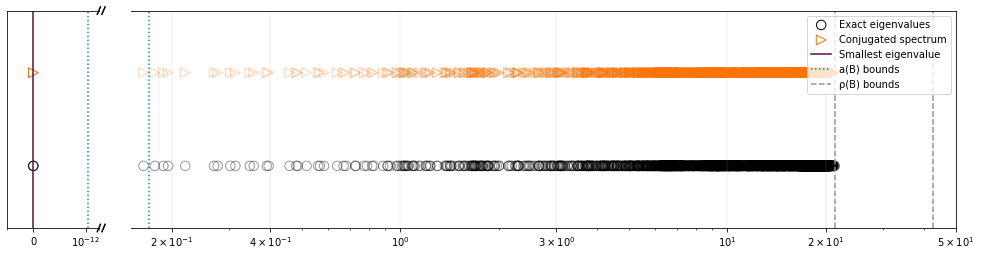

In [107]:
# Plot of spectrum
fig, ax = plt.subplots(1, 2, sharey=True, facecolor='w', figsize=(17,4), width_ratios = [1/10, 1-1/10])

# plot the same data on both axes
ax[0].scatter(Exact_Spectrum + λ, [0]*nm, s = 90, alpha = 0.4, marker = 'o', 
            edgecolors='black', facecolors='none')
ax[0].scatter(λ, [0], s = 90, alpha = 1, marker = 'o', 
            edgecolors='black', facecolors='none')
ax[0].scatter(λ, [0.3], s = 95, alpha = 1, marker = '>', 
            color='xkcd:orange', facecolors='none')

ax[1].scatter(Exact_Spectrum[1:] + λ, [0]*(nm-1), s = 90, alpha = 0.4, marker = 'o', 
            edgecolors='black', facecolors='none')
ax[1].scatter(λ, [0], s = 90, alpha = 1, marker = 'o', 
            edgecolors='black', facecolors='none', label='Exact eigenvalues')
ax[1].scatter(λ, [0.3], s = 95, alpha = 1, marker = '>', 
            color='xkcd:orange', facecolors='none', label='Conjugated spectrum')

ax[1].scatter(Whole_Spectrum.real, [0.3]*nm, s = 95, alpha = 0.3, marker = '>', 
            color='xkcd:orange', facecolors='none')


ax[0].axvline(x=λ, color='xkcd:plum', linestyle='-')
ax[1].axvline(x=λ, color='xkcd:plum', linestyle='-', label='Smallest eigenvalue')

ax[0].axvline(x=μ*ANOVA[0,1:].min(), color='xkcd:teal', linestyle=':')
ax[1].axvline(x=(nm/(nm-1)) * μ * η.min(), color='xkcd:teal', linestyle=':', label='a(B) bounds')
#plt.axhline(y= μ * 1.01*(η-1).max(), color='violet', linestyle='-', label='upper approximation')
ax[1].axvline(x=μ * 1*(η).max(), color='xkcd:grey', linestyle='--', label='ρ(B) bounds')
ax[1].axvline(x=μ * 2*(η).max(), color='xkcd:grey', linestyle='--')


# Define domain of each part
ax[0].set_xlim(-1e-12, 2.5e-12)
ax[1].set_xlim(1.5e-1, 5e+1)
plt.ylim(-0.2, 0.5)


# hide the spines between ax[0] and ax[1]
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].tick_params(labelleft=False, left=False)
ax[1].tick_params(labelleft=False, left=False)

#plt.xscale('log')
ax[0].set_xscale('symlog')
ax[1].set_xscale('log')


# Diagonal lines
b_d = .017  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-b_d, 1+b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1-b_d, 1+b_d), (-b_d, +b_d), **kwargs)

ax[0].plot((1+2*b_d, 1+4*b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1+2*b_d, 1+4*b_d), (-b_d, +b_d), **kwargs)

# Adjust spacing between the two plots
plt.subplots_adjust(wspace=0.07)

# Add grid lines
plt.grid('on', which = 'major', linewidth = 0.2)
ax[1].yaxis.grid(False)

# Add more ticks in x-axis
ax_base = [-1,-1, 0,0,1,1,1]
ax_val  = [ 2, 4, 1,3,1,2,5]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
plt.xticks(ax_loc, ax_lbl )
ax[1].set_xticks(ax_loc, ax_lbl)

ax[0].set_xticks([0, 2e-12], [plt.Text(0,0, '$\\mathdefault{0}$'), plt.Text(1e-12, 0, '$\\mathdefault{ 10^{-12} }$')])


# Present legend
ax[1].legend(loc='upper right')
plt.show()

## Decoupling

We already know that $\mathsf{A}_U$ is block diagonal, so we can solve the system by decoupling each block:
\begin{align*}
    \begin{pmatrix}
        \lambda & 0_{n-1}^\top 
        \\
        0_{n-1} & (\mathsf{A}_{U})_{(2:n,2:n)}
    \end{pmatrix}
    \begin{pmatrix}
        y_1
        \\
        y_{(2:n)}
    \end{pmatrix}
    =
    \lambda
    \begin{pmatrix}
        g_1
        \\
        g_{(2:n)}
    \end{pmatrix}
\end{align*}
then we know that $y_1 = g_1$. 

In [31]:
# The unitary transformation does not depend on the value of the regulariser
e_1     = zeros(nm);       e_1[0] = 1.0
not_e_1 = ones(nm);    not_e_1[0] = 0.0
aux_h = np.arange(nm, dtype = '<f8')
aux_d = np.reciprocal(np.sqrt( np.concatenate( ([nm], np.arange(2,nm+1) * np.arange(1,nm) ) ).astype('<f8') ))

def MV_basis_U_T(v):       return aux_d * (np.roll( np.cumsum(v),1) - (aux_h * v))
def MV_basis_U(v):
    w = aux_d * v
    return  ((w.sum() - np.cumsum(w)) * np.flip(not_e_1)) - (aux_h * w) + w[0]

In [32]:
from scipy.sparse.linalg import LinearOperator, cg

In [33]:
λ = 1e-9;    ff = f.flatten();    l_u = λ * ff
U_t_A_U = (U.T).dot( np.diag(0*ones(nm)) + μ * ( np.diag(η) - ANOVA ) ).dot(U)

In [34]:
Aᵤᵦ = U_t_A_U[1:,1:] + np.diag([λ]*(nm-1), 0)
λfᵤ = MV_basis_U_T(λ * ff)[1:]    # Project partial RHS

In [35]:
Prec_RHS = MV_basis_U_T(l_u)    # Project RHS
Prec_x_0 = MV_basis_U_T(ff)     # Project initial solution

We can implement this in operator form via projecting back into $\mathbb{R}^n$ by appending a zero at the top of each $(n-1$–dimensional vector (which would amount to avoid the first row of $U$) and then remove the first entry of $U^\top A U_{\{:,2:n\}}$, amounting to removing the first row of $U^\top$:

In [36]:
# Define subblock of system
def MV_basis_MAM(v):
    # Project back v, change basis by U, apply A, then U.T, and project; i.e., (P U.T A U) P.T v
    w = np.concatenate( ([0.0], v) )
    w = MV_basis_U_T( A.dot( MV_basis_U( w ) ) )
    return w[1:]

MAM = LinearOperator((nm-1,nm-1), dtype=np.float64, matvec=MV_basis_MAM, rmatvec=MV_basis_MAM)

There is one caveat in the implementation of the projection as it requires the computation of the whole of $ \mathsf{A}_U x $, with $x$ in the original dimension, before projecting back to the workingspace dimension. As a result, what we can do is to compute $ (\mathsf{A}_U)_{\{2:n,2:n\}}x $ using only the $n-1$ last columns of $U$ via
\begin{align*}
    (\mathsf{A}_U)_{\{2:n,2:n\}} = (U_{\{:,2:n\}})^\top A U_{\{:,2:n\}}
\end{align*}
We tested this, but didn't observe much performance gain. It actually requires extra computational work.

---

We know that $P_\mathsf{d}$ is a good preconditioner for $\lambda$ large. That is, $ P_\mathsf{d} A $ behaves well numerically and has a bounded condition number when $\lambda > 1$. In our case, we know that $\mathsf{A}_U$ is a block matrix and after we remove the first, ill conditioned subblock, the second block has the condition number $ \frac{\rho(B) + \lambda}{a(B) + \lambda} $. What we would like to understand is if we can apply $P_\mathsf{d}$, or a projection of it, to the subblock to improve its condition number.

Notice that $ P_\mathsf{d} A = U (U^\top P_\mathsf{d}U) U^\top U (U^\top A U) U^\top = U (U^\top P_\mathsf{d}U) \mathsf{A}_U U^\top$, hence the preconditioning properties in $P_\mathsf{d} A$ would replicate in the operator $(U^\top P_\mathsf{d}U) \mathsf{A}_U$ under the change of basis.

In [37]:
ηᵧᵗʷᵒ = Full_W(35.0/(2**0.5)).sum(0) - 1.0;                # Obtain the sum of the squares of each sub ANOVA kernel
(ηᵧᵗʷᵒ * k_weight <= (ANOVA**2).sum(0)).all() and ((ANOVA**2).sum(0) <= ηᵧᵗʷᵒ).all()

True

In [38]:
diag_Pₐ = (μ * η + λ)**-1                                         # Inverse diagonal of Pₐ
diag_Pᵦ = ((k_weight * (μ**2) * ηᵧᵗʷᵒ) + (μ * η + λ)**2)**-0.5    # Inverse diagonal of Pᵦ
diag_Pᵪ = (((μ**2) * ηᵧᵗʷᵒ) + (μ * η + λ)**2)**-0.5               # Inverse diagonal of Pᵦ * L

In [39]:
pd.concat([pd.DataFrame([describe(diag_Pₐ)], columns=describe(diag_Pₐ)._fields), 
           pd.DataFrame([describe(diag_Pᵦ)], columns=describe(diag_Pᵦ)._fields),
           pd.DataFrame([describe(diag_Pᵪ)], columns=describe(diag_Pᵪ)._fields)], ignore_index=True)

,nobs,minmax,mean,variance,skewness,kurtosis
0,3630,"(0.04731597187027558, 5.757796114906498)",0.119966,0.065594,11.185004,173.768833
1,3630,"(0.04731566143103023, 5.754379785915313)",0.119958,0.065554,11.181280,173.649750
2,3630,"(0.04730324886950892, 5.6225228595984715)",0.119629,0.064011,11.037347,169.079703


The three preconditioners are a little different (in spectral terms)

In [40]:
print(np.around([abs(diag_Pₐ-diag_Pᵦ).max(), abs(diag_Pₐ-diag_Pᵪ).max()],4))

[0.0034 0.1353]


In [45]:
# Use square roots for symmetric systems
U_t_Pₐ_U = U.T.dot(np.diag(diag_Pₐ**0.5)).dot(U)
U_t_Pᵦ_U = U.T.dot(np.diag(diag_Pᵦ**0.5)).dot(U)
U_t_Pᵪ_U = U.T.dot(np.diag(diag_Pᵪ**0.5)).dot(U)

In [43]:
# We make a copy for testing
UTAU = U_t_A_U.copy()
UTAU[0,:] = UTAU[:,0] = 0.0

In [93]:
DₐAₓ = (U_t_Pₐ_U.dot(UTAU + np.diag([λ]*(nm), 0)).dot(U_t_Pₐ_U))
DᵦAₓ = (U_t_Pᵦ_U.dot(UTAU + np.diag([λ]*(nm), 0)).dot(U_t_Pᵦ_U))
DᵪAₓ = (U_t_Pᵪ_U.dot(UTAU + np.diag([λ]*(nm), 0)).dot(U_t_Pᵪ_U))

In [94]:
# Full spectra of full preconditioned operators
start = time.time()
Pₐ_Spectrum = eigvalsh( DₐAₓ, check_finite='false')    # This has the same spectrum as PA: eigvalsh( (np.diag(diag_Pₐ**0.5)).dot( np.diag(λ*ones(nm)) + μ * ( np.diag(η) - ANOVA ) ).dot(np.diag(diag_Pₐ**0.5)), check_finite='false')
end = time.time()
display(Latex(f'Time for $\\texttt{{eigsh}} (U^\\top \mathsf{{P}}_{{\mathsf{{a}} }}^{{-1}} A\, U)$: $\\hspace{{0.5em}}$' + '{0:.2f} [s]'.format(end-start) ))

start = time.time()
Pᵦ_Spectrum = eigvalsh( DᵦAₓ, check_finite='false')
end = time.time()
display(Latex(f'Time for $\\texttt{{eigsh}} (U^\\top \mathsf{{P}}_{{\mathsf{{b}} }}^{{-1}} A\, U)$: $\\hspace{{0.5em}}$' + '{0:.2f} [s]'.format(end-start) ))

start = time.time()
Pᵪ_Spectrum = eigvalsh( DᵪAₓ, check_finite='false')
end = time.time()
display(Latex(f'Time for $\\texttt{{eigsh}} (U^\\top \mathsf{{P}}_{{\mathsf{{c}} }}^{{-1}} A\, U)$: $\\hspace{{0.5em}}$' + '{0:.2f} [s]'.format(end-start) ))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Let's plot the effects of the three preconditioners:

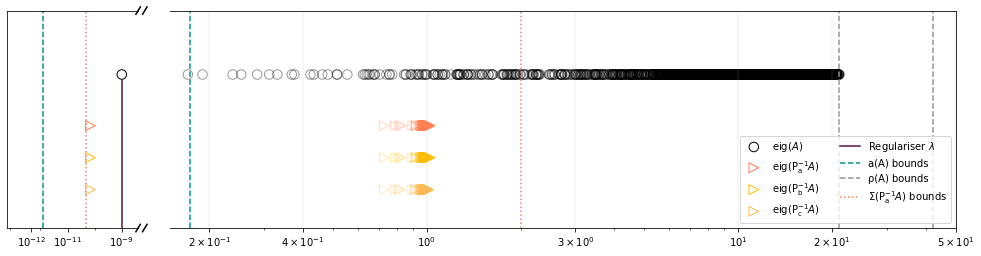

In [429]:
# Plot of spectrum
fig, ax = plt.subplots(1, 2, sharey=True, facecolor='w', figsize=(17,4), width_ratios = [1/7, 1-1/7])

# plot the same data on both axes
'''ax[0].scatter(Exact_Spectrum + λ, [0]*nm, s = 90, alpha = 0.4, marker = 'o', 
            edgecolors='black', facecolors='none')'''
ax[0].scatter(λ, [1], s = 90, alpha = 1, marker = 'o', 
            edgecolors='black', facecolors='none')
ax[0].scatter(Pₐ_Spectrum[0], [0.6], s = 95, alpha = 1, marker = '>', 
            color='#FF7F50', facecolors='none')
ax[0].scatter(Pᵦ_Spectrum[0], [0.35], s = 95, alpha = 1, marker = '>', 
            color='#FFBF00', facecolors='none')
ax[0].scatter(Pᵪ_Spectrum[0], [0.1], s = 95, alpha = 1, marker = '>', 
            color='#FEBA4F', facecolors='none')

ax[1].scatter(Exact_Spectrum[1:] + λ, [1]*(nm-1), s = 90, alpha = 0.4, marker = 'o', 
            edgecolors='black', facecolors='none')
ax[1].scatter(λ, [0], s = 90, alpha = 1, marker = 'o', edgecolors='black', facecolors='none', label='$\mathrm{eig}(A)$')
ax[1].scatter(Pₐ_Spectrum[0], [0.6], s = 95, alpha = 1, marker = '>', 
              color='#FF7F50', facecolors='none', label='$\mathrm{eig}(\mathsf{P}_{\mathsf{a}}^{-1}A)$')
ax[1].scatter(Pᵦ_Spectrum[0], [0.35], s = 95, alpha = 1, marker = '>', 
              color='#FFBF00', facecolors='none', label='$\mathrm{eig}(\mathsf{P}_{\mathsf{b}}^{-1}A)$')
ax[1].scatter(Pᵪ_Spectrum[0], [0.1], s = 95, alpha = 1, marker = '>', 
              color='#FEBA4F', facecolors='none', label='$\mathrm{eig}(\mathsf{P}_{\mathsf{c}}^{-1}A)$')

ax[1].scatter(Pₐ_Spectrum, [0.6]*nm, s = 95, alpha = 0.3, marker = '>', 
            color='#FF7F50', facecolors='none')
ax[1].scatter(Pᵦ_Spectrum, [0.35]*nm, s = 95, alpha = 0.3, marker = '>', 
            color='#FFBF00', facecolors='none')
ax[1].scatter(Pᵪ_Spectrum, [0.1]*nm, s = 95, alpha = 0.3, marker = '>', 
            color='#FEBA4F', facecolors='none')


ax[0].axvline(x=λ, ymax = 0.92*(1.35+0.5)/2.5, color='xkcd:plum', linestyle='-')
ax[1].axvline(x=λ, color='xkcd:plum', linestyle='-', label='Regulariser $\lambda$')

ax[0].axvline(x=μ*ANOVA[0,1:].min(), color='xkcd:teal', linestyle='--')
ax[0].axvline(x=λ/(λ+μ*η.max()), color = '#FF7F50', linestyle=':')

ax[1].axvline(x=(nm/(nm-1)) * μ * η.min(), color='xkcd:teal', linestyle='--', label='a(A) bounds')
#plt.axhline(y= μ * 1.01*(η-1).max(), color='violet', linestyle='-', label='upper approximation')
ax[1].axvline(x=μ * 1*(η).max(), color='xkcd:grey', linestyle='--', label='ρ(A) bounds')
ax[1].axvline(x=μ * 2*(η).max(), color='xkcd:grey', linestyle='--')

ax[1].axvline(x=min(2.0, (nm/(nm-1))*(Whole_Spectrum[-1]/Whole_Spectrum[1]), Whole_Spectrum[-1]/η.min()), 
              color = '#FF7F50', linestyle=':', label='$\Sigma(\mathsf{P}_{\mathsf{a}}^{-1}A)$ bounds')


# Define domain of each part
ax[0].set_xlim(-1e-13, 4e-9)
ax[1].set_xlim(1.5e-1, 5e+1)
plt.ylim(-0.2, 1.5)


# hide the spines between ax[0] and ax[1]
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].tick_params(labelleft=False, left=False)
ax[1].tick_params(labelleft=False, left=False)

#plt.xscale('log')
ax[0].set_xscale('symlog', linthresh= 1e-12)
ax[1].set_xscale('log')


# Diagonal lines
b_d = .017  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-b_d, 1+b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1-b_d, 1+b_d), (-b_d, +b_d), **kwargs)

ax[0].plot((1+2*b_d, 1+4*b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1+2*b_d, 1+4*b_d), (-b_d, +b_d), **kwargs)

# Adjust spacing between the two plots
plt.subplots_adjust(wspace=0.07)

# Add grid lines
plt.grid('on', which = 'major', linewidth = 0.2)
ax[1].yaxis.grid(False)

# Add more ticks in x-axis
ax_base = [-1,-1, 0,0,1,1,1]
ax_val  = [ 2, 4, 1,3,1,2,5]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
plt.xticks(ax_loc, ax_lbl )
ax[1].set_xticks(ax_loc, ax_lbl)

ax[0].set_xticks([7e-13, 1e-11, 1e-9], 
                 [plt.Text(1e-12,0, '$\\mathdefault{ 10^{-12} }$'), 
                  plt.Text(1e-11, 0, '$\\mathdefault{ 10^{-11} }$'), plt.Text(1e-9, 0, '$\\mathdefault{ 10^{-9} }$')])


# Present legend
ax[1].legend(loc='lower right', ncols = 2)

fig.savefig('Eigs_Diagonal_Precs[3].pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In the paper we might just discuss the effects of two preconditioners, so let's remove the effect of $\mathsf{P}_{\mathsf c}$:

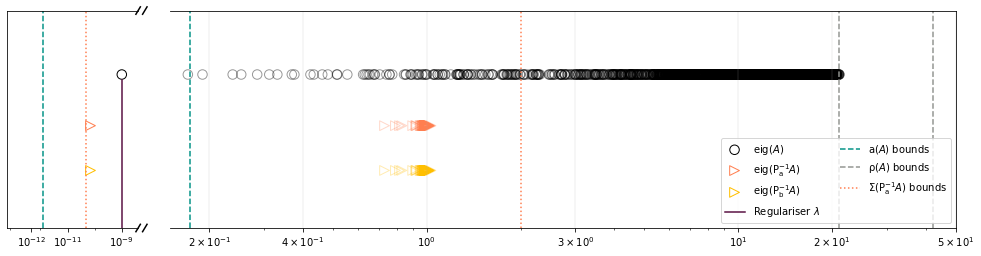

In [478]:
# Plot of spectrum
fig, ax = plt.subplots(1, 2, sharey=True, facecolor='w', figsize=(17,4), width_ratios = [1/7, 1-1/7])

# plot the same data on both axes
'''ax[0].scatter(Exact_Spectrum + λ, [0]*nm, s = 90, alpha = 0.4, marker = 'o', 
            edgecolors='black', facecolors='none')'''
ax[0].scatter(λ, [1], s = 90, alpha = 1, marker = 'o', 
            edgecolors='black', facecolors='none')
ax[0].scatter(Pₐ_Spectrum[0], [0.6], s = 95, alpha = 1, marker = '>', 
            color='#FF7F50', facecolors='none')
ax[0].scatter(Pᵦ_Spectrum[0], [0.25], s = 95, alpha = 1, marker = '>', 
            color='#FFBF00', facecolors='none')

ax[1].scatter(Exact_Spectrum[1:] + λ, [1]*(nm-1), s = 90, alpha = 0.4, marker = 'o', 
            edgecolors='black', facecolors='none')
ax[1].scatter(λ, [0], s = 90, alpha = 1, marker = 'o', edgecolors='black', facecolors='none', label='$\mathrm{eig}(A)$')
ax[1].scatter(Pₐ_Spectrum[0], [0.6], s = 95, alpha = 1, marker = '>', 
              color='#FF7F50', facecolors='none', label='$\mathrm{eig}(\mathsf{P}_{\mathsf{a}}^{-1}A)$')
ax[1].scatter(Pᵦ_Spectrum[0], [0.25], s = 95, alpha = 1, marker = '>', 
              color='#FFBF00', facecolors='none', label='$\mathrm{eig}(\mathsf{P}_{\mathsf{b}}^{-1}A)$')

ax[1].scatter(Pₐ_Spectrum, [0.6]*nm, s = 95, alpha = 0.3, marker = '>', 
            color='#FF7F50', facecolors='none')
ax[1].scatter(Pᵦ_Spectrum, [0.25]*nm, s = 95, alpha = 0.3, marker = '>', 
            color='#FFBF00', facecolors='none')


ax[0].axvline(x=λ, ymax = 0.92*(1.35+0.5)/2.5, color='xkcd:plum', linestyle='-')
ax[1].axvline(x=λ, color='xkcd:plum', linestyle='-', label='Regulariser $\lambda$')

ax[0].axvline(x=μ*ANOVA[0,1:].min(), color='xkcd:teal', linestyle='--')
ax[0].axvline(x=λ/(λ+μ*η.max()), color = '#FF7F50', linestyle=':')
#ax[0].axvline(x=λ/(λ + η.min()), color = '#FF7F50', linestyle=':' )

ax[1].axvline(x=(nm/(nm-1)) * μ * η.min(), color='xkcd:teal', linestyle='--', label='a($A$) bounds')
#plt.axhline(y= μ * 1.01*(η-1).max(), color='violet', linestyle='-', label='upper approximation')
ax[1].axvline(x=μ * 1*(η).max(), color='xkcd:grey', linestyle='--', label='ρ($A$) bounds')
ax[1].axvline(x=μ * 2*(η).max(), color='xkcd:grey', linestyle='--')

ax[1].axvline(x=min(2.0, (nm/(nm-1))*(Whole_Spectrum[-1]/Whole_Spectrum[1]), Whole_Spectrum[-1]/η.min()), 
              color = '#FF7F50', linestyle=':', label='$\Sigma(\mathsf{P}_{\mathsf{a}}^{-1}A)$ bounds')
#ax[1].axvline(x=μ * 1*(η).max() * diag_Pₐ.min(), color = '#FEBA4F', linestyle=':' )
#ax[1].axvline(x=λ/(λ + η.min()), color = '#FF7F50', linestyle=':', label='$\min\,\Sigma(\mathsf{P}_{\mathsf{a}}^{-1}A)$ bounds')


# Define domain of each part
ax[0].set_xlim(-1e-13, 4e-9)
ax[1].set_xlim(1.5e-1, 5e+1)
plt.ylim(-0.2, 1.5)


# hide the spines between ax[0] and ax[1]
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].tick_params(labelleft=False, left=False)
ax[1].tick_params(labelleft=False, left=False)

#plt.xscale('log')
ax[0].set_xscale('symlog', linthresh= 1e-12)
ax[1].set_xscale('log')


# Diagonal lines
b_d = .017  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-b_d, 1+b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1-b_d, 1+b_d), (-b_d, +b_d), **kwargs)

ax[0].plot((1+2*b_d, 1+4*b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1+2*b_d, 1+4*b_d), (-b_d, +b_d), **kwargs)

# Adjust spacing between the two plots
plt.subplots_adjust(wspace=0.07)

# Add grid lines
plt.grid('on', which = 'major', linewidth = 0.2)
ax[1].yaxis.grid(False)

# Add more ticks in x-axis
ax_base = [-1,-1, 0,0,1,1,1]
ax_val  = [ 2, 4, 1,3,1,2,5]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
plt.xticks(ax_loc, ax_lbl )
ax[1].set_xticks(ax_loc, ax_lbl)

ax[0].set_xticks([7e-13, 1e-11, 1e-9], 
                 [plt.Text(1e-12,0, '$\\mathdefault{ 10^{-12} }$'), 
                  plt.Text(1e-11, 0, '$\\mathdefault{ 10^{-11} }$'), plt.Text(1e-9, 0, '$\\mathdefault{ 10^{-9} }$')])


# Present legend
ax[1].legend(loc='lower right', ncols = 2)

fig.savefig('Eigs_Diagonal_Precs[2].pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Oooops there was a wee mistake with the lower bound on the algebraic connectivity:

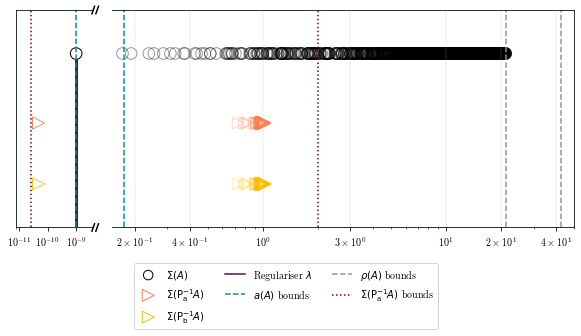

In [1092]:
# Plot of spectrum
fig, ax = plt.subplots(1, 2, sharey=True, facecolor='w', figsize=(10,4), width_ratios = [1/7, 1-1/7])
m_s_a = 1.5*95        # Marker size
m_s_b = 1.5*90

# plot the same data on both axes
'''ax[0].scatter(Exact_Spectrum + λ, [0]*nm, s = 90, alpha = 0.4, marker = 'o', 
            edgecolors='black', facecolors='none')'''
ax[0].scatter(λ, [1], s = m_s_b, alpha = 1, marker = 'o', 
            edgecolors='black', facecolors='none')
ax[0].scatter(Pₐ_Spectrum[0], [0.6], s = m_s_a, alpha = 1, marker = '>', 
            color='#FF7F50', facecolors='none')
ax[0].scatter(Pᵦ_Spectrum[0], [0.25], s = m_s_a, alpha = 1, marker = '>', 
            color='#FFBF00', facecolors='none')

ax[1].scatter(Exact_Spectrum[1:] + λ, [1]*(nm-1), s = m_s_b, alpha = 0.4, marker = 'o', 
            edgecolors='black', facecolors='none')
ax[1].scatter(λ, [0], s = 90, alpha = 1, marker = 'o', edgecolors='black', facecolors='none', label='$\Sigma(A)$')
ax[1].scatter(Pₐ_Spectrum[0], [0.6], s = m_s_a, alpha = 1, marker = '>', 
              color='#FF7F50', facecolors='none', label='$\Sigma(\mathsf{P}_{\mathsf{a}}^{-1}A)$')
ax[1].scatter(Pᵦ_Spectrum[0], [0.25], s = m_s_a, alpha = 1, marker = '>', 
              color='#FFBF00', facecolors='none', label='$\Sigma(\mathsf{P}_{\mathsf{b}}^{-1}A)$')

ax[1].scatter(Pₐ_Spectrum, [0.6]*nm, s = m_s_a, alpha = 0.3, marker = '>', 
            color='#FF7F50', facecolors='none')
ax[1].scatter(Pᵦ_Spectrum, [0.25]*nm, s = m_s_a, alpha = 0.3, marker = '>', 
            color='#FFBF00', facecolors='none')


ax[0].axvline(x=λ, ymax = 0.96*(1.5+0.5)/2.5, color='xkcd:plum', linestyle='-', linewidth=3.0)
ax[1].axvline(x=λ, color='xkcd:plum', linestyle='-', label='Regulariser $\lambda$')

ax[0].axvline(x=μ*ANOVA[0,1:].min() + λ, color='xkcd:teal', linestyle='--')
ax[0].axvline(x=λ/(λ+μ*η.max()), color = '#780000', linestyle=':')
ax[0].axvline(x=λ/(λ + η.min()), color = '#780000', linestyle=':' )                                           # Inner

ax[1].axvline(x=(nm/(nm-1)) * μ * η.min(), color='xkcd:teal', linestyle='--', label='$a(A)$ bounds')
#plt.axhline(y= μ * 1.01*(η-1).max(), color='violet', linestyle='-', label='upper approximation')
ax[1].axvline(x=μ * 1*(η).max(), color='xkcd:grey', linestyle='--', label='$\\rho(A)$ bounds')
ax[1].axvline(x=μ * 2*(η).max(), color='xkcd:grey', linestyle='--')

ax[1].axvline(x=min(2.0, (nm/(nm-1))*(Whole_Spectrum[-1]/Whole_Spectrum[1]), Whole_Spectrum[-1]/η.min()), 
              color = '#780000', linestyle=':', label='$\Sigma(\mathsf{P}_{\mathsf{a}}^{-1}A)$ bounds')
ax[1].axvline(x=μ * 1*(η).max() * diag_Pₐ.min(), color = '#780000', linestyle=':')                           # Inner
#ax[1].axvline(x=λ/(λ + η.min()), color = '#780000', linestyle=':', label='$\min\,\Sigma(\mathsf{P}_{\mathsf{a}}^{-1}A)$ bounds')


# Define domain of each part
ax[0].set_xlim(-1e-14, 4e-9)
ax[1].set_xlim(1.5e-1, 5e+1)
#plt.ylim(-0.2, 1.5)
plt.ylim(0, 1.25)


# hide the spines between ax[0] and ax[1]
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].tick_params(labelleft=False, left=False)
ax[1].tick_params(labelleft=False, left=False)

#plt.xscale('log')
ax[0].set_xscale('symlog', linthresh= 1e-10)
ax[1].set_xscale('log')


# Diagonal lines
b_d = .017  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-b_d, 1+b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1-b_d, 1+b_d), (-b_d, +b_d), **kwargs)

ax[0].plot((1+2*b_d, 1+4*b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1+2*b_d, 1+4*b_d), (-b_d, +b_d), **kwargs)

# Adjust spacing between the two plots
plt.subplots_adjust(wspace=0.07)

# Add grid lines
plt.grid('on', which = 'major', linewidth = 0.2)
ax[1].yaxis.grid(False)

# Add more ticks in x-axis
ax_base = [-1,-1, 0,0,1,1,1]
ax_val  = [ 2, 4, 1,3,1,2,4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
plt.xticks(ax_loc, ax_lbl )
ax[1].set_xticks(ax_loc, ax_lbl, fontname='CMR10')

ax[0].set_xticks([1e-11, 1e-10, 1e-9], 
                 [plt.Text(1e-11,0, '$\\mathdefault{ 10^{-11} }$'), 
                  plt.Text(1e-10, 0, '$\\mathdefault{ 10^{-10} }$'), plt.Text(1e-9, 0, '$\\mathdefault{ 10^{-9} }$')], fontname='CMR10')

# Stronger marker
ax[0].scatter(Pₐ_Spectrum[0], [0.6],  s = m_s_a*0.72, alpha = 1, marker = '>', color='none', facecolors='w', zorder=3)
ax[0].scatter(Pᵦ_Spectrum[0], [0.25], s = m_s_a*0.72, alpha = 1, marker = '>', color='none', facecolors='w', zorder=3)

# Present legend
#ax[1].legend(loc='lower right', ncols = 2)
leg_handles, leg_labels = ax[1].get_legend_handles_labels()
fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=3, bbox_transform=plt.gcf().transFigure, prop={'family': 'CMR10'})


fig.savefig('Eigs_Diagonal_Precs[2]_v2_Inner.pdf', bbox_inches='tight', pad_inches=0)

#import pickle as pl
#with open('Eigs_Diagonal_Precs[2]_v2_Inner.pickle', 'wb') as file:
#    pl.dump(fig, file)
plt.show()

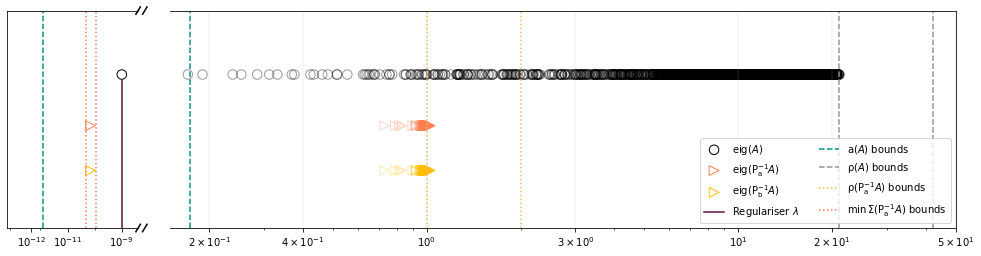

In [477]:
# Add this
'''ax[0].axvline(x=λ/(λ+μ*η.max()), color = '#FF7F50', linestyle=':')
ax[0].axvline(x=λ/(λ + η.min()), color = '#FF7F50', linestyle=':' )

ax[1].axvline(x=μ * 1*(η).max() * diag_Pₐ.min(), color = '#FEBA4F', linestyle=':' )
ax[1].axvline(x=λ/(λ + η.min()), color = '#FF7F50', linestyle=':', label='$\min\,\Sigma(\mathsf{P}_{\mathsf{a}}^{-1}A)$ bounds')'''

The absolute difference between the three diagonal preconditioners is quite small:

In [423]:
print(np.around([norm(Pᵦ_Spectrum - Pₐ_Spectrum), norm(Pᵪ_Spectrum - Pₐ_Spectrum)], 4))    # similar to component-wise rel error

[0.0015 0.0568]


But the relative error is not that high:

In [420]:
np.around([norm(Pᵦ_Spectrum - Pₐ_Spectrum)/norm(Pₐ_Spectrum), norm(Pᵪ_Spectrum - Pₐ_Spectrum)/norm(Pₐ_Spectrum)], 6)

array([2.50e-05, 9.42e-04])

In [482]:
# Free up some memory
del U_t_Pₐ_U, U_t_Pᵦ_U, U_t_Pᵪ_U

---

### Preconditioned projections

In [670]:
# Use square roots for symmetric systems
U_t_Pₐ_U = U.T.dot(np.diag(diag_Pₐ)).dot(U)
U_t_Pᵦ_U = U.T.dot(np.diag(diag_Pᵦ)).dot(U)
U_t_Pᵪ_U = U.T.dot(np.diag(diag_Pᵪ)).dot(U)
DₐAₓ = U_t_Pₐ_U.dot(UTAU + np.diag([λ]*(nm), 0))
DᵦAₓ = U_t_Pᵦ_U.dot(UTAU + np.diag([λ]*(nm), 0))
DᵪAₓ = U_t_Pᵪ_U.dot(UTAU + np.diag([λ]*(nm), 0))

In [671]:
Lower_Rₐ_block = DₐAₓ[1:,1:].view()    # THIS WAS WRONG: WE FORGOT THAT THE PROJECTION IS NOT EQUIVALENT!
Lower_Rᵦ_block = DᵦAₓ[1:,1:].view()
Lower_Rᵪ_block = DᵪAₓ[1:,1:].view()

In [675]:
# Partial spectra of preconditioned operators
start = time.time()
Dₐ_Spectrum = eigvals( Lower_Rₐ_block, check_finite='false').real
end = time.time()
display(Latex(f'Time for $\\texttt{{eigs}} \, \\big(\pi_2 (\mathsf{{D}}_{{\mathsf{{X,a}} }}^{{-1}} ' + 
              f'\mathsf{{A}}_{{\mathsf{{X}} }} ) \\big)$: $\\hspace{{0.5em}}$' + '{0:.2f} [s]'.format(end-start) ))

start = time.time()
Dᵦ_Spectrum = eigvals( Lower_Rᵦ_block, check_finite='false').real
end = time.time()
display(Latex(f'Time for $\\texttt{{eigs}} \, \\big(\pi_2 (\mathsf{{D}}_{{\mathsf{{X,b}} }}^{{-1}} ' + 
              f'\mathsf{{A}}_{{\mathsf{{X}} }} ) \\big)$: $\\hspace{{0.5em}}$' + '{0:.2f} [s]'.format(end-start) ))

start = time.time()
Dᵪ_Spectrum = eigvals( Lower_Rᵪ_block, check_finite='false').real
end = time.time()
display(Latex(f'Time for $\\texttt{{eigs}} \, \\big(\pi_2 (\mathsf{{D}}_{{\mathsf{{X,c}} }}^{{-1}} ' + 
              f'\mathsf{{A}}_{{\mathsf{{X}} }} ) \\big)$: $\\hspace{{0.5em}}$' + '{0:.2f} [s]'.format(end-start) ))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [681]:
Dₐ_Spectrum.sort(), Dᵦ_Spectrum.sort(), Dᵪ_Spectrum.sort();

In [682]:
print(Dₐ_Spectrum[[0,-1]], Dᵦ_Spectrum[[0,-1]], Dᵪ_Spectrum[[0,-1]])

[0.7317979  1.03202212] [0.73177964 1.03150679] [0.73104112 1.01429239]


In [683]:
print(Pₐ_Spectrum[[1,-1]], Pᵦ_Spectrum[[1,-1]], Pᵪ_Spectrum[[1,-1]])

[0.7317979  1.03202212] [0.73177964 1.03150679] [0.73104112 1.01429239]


Let's check the condition number of each system:

In [838]:
np.asarray([Pₐ_Spectrum[-1]/Pₐ_Spectrum[0], Pᵦ_Spectrum[-1]/Pᵦ_Spectrum[0], Pᵪ_Spectrum[-1]/Pᵪ_Spectrum[0]])

array([1.46820216e+10, 1.46748293e+10, 1.44351615e+10])

In [837]:
np.around([Dₐ_Spectrum[-1]/Dₐ_Spectrum[0], Dᵦ_Spectrum[-1]/Dᵦ_Spectrum[0], Dᵪ_Spectrum[-1]/Dᵪ_Spectrum[0]], 4)

array([1.4103, 1.4096, 1.3875])

---

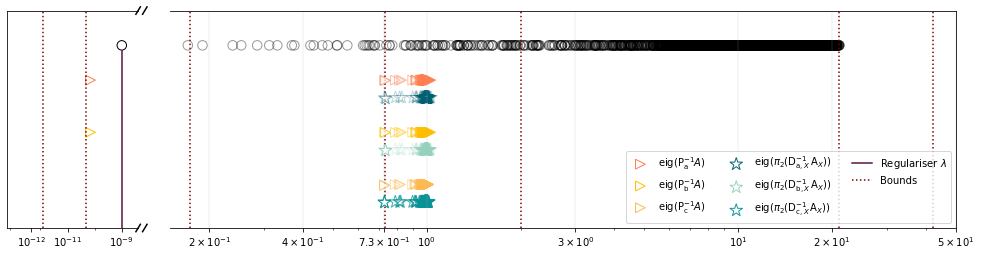

In [822]:
# Plot of spectra
fig, ax = plt.subplots(1, 2, sharey=True, facecolor='w', figsize=(17,4), width_ratios = [1/7, 1-1/7])

# plot the same data on both axes
ax[0].scatter(λ, [1.4], s = 90, alpha = 1, marker = 'o', 
            edgecolors='black', facecolors='none')
ax[0].scatter(Pₐ_Spectrum[0], [1], s = 95, alpha = 1, marker = '>', 
            color='#FF7F50', facecolors='none')
ax[0].scatter(Pᵦ_Spectrum[0], [0.4], s = 95, alpha = 1, marker = '>', 
            color='#FFBF00', facecolors='none')


# Capture label
ax[1].scatter(Pₐ_Spectrum[0], [1], s = 95, alpha = 1, marker = '>', 
              color='#FF7F50', facecolors='none', label='$\mathrm{eig}(\mathsf{P}_{\mathsf{a}}^{-1}A)$')
ax[1].scatter(Pᵦ_Spectrum[0], [0.25], s = 95, alpha = 1, marker = '>', 
              color='#FFBF00', facecolors='none', label='$\mathrm{eig}(\mathsf{P}_{\mathsf{b}}^{-1}A)$')
ax[1].scatter(Pᵪ_Spectrum[0], [-0.2], s = 95, alpha = 1, marker = '>', 
              color='#FEBA4F', facecolors='none', label='$\mathrm{eig}(\mathsf{P}_{\mathsf{c}}^{-1}A)$')
ax[1].scatter(λ, [0.85], s = 175, alpha = 0.95, marker = '*', 
            color='#005f73', facecolors='none', label='$\mathrm{eig}( \pi_2 ( \mathsf{D}_{\mathsf{a},X}^{-1} \, \mathsf{A}_{X}) )$')
ax[1].scatter(λ, [0.25], s = 175, alpha = 0.95, marker = '*', 
            color='#94d2bd', facecolors='none', label='$\mathrm{eig}( \pi_2 ( \mathsf{D}_{\mathsf{b},X}^{-1} \, \mathsf{A}_{X}) )$')
ax[1].scatter(λ, [-0.2], s = 175, alpha = 0.95, marker = '*', 
            color='#0a9396', facecolors='none', label='$\mathrm{eig}( \pi_2 ( \mathsf{D}_{\mathsf{c},X}^{-1} \, \mathsf{A}_{X}) )$')

#
ax[1].scatter(Exact_Spectrum[1:] + λ, [1.4]*(nm-1), s = 90, alpha = 0.4, marker = 'o', 
            edgecolors='black', facecolors='none')
ax[1].scatter(Pₐ_Spectrum, [1]*nm, s = 95, alpha = 0.5, marker = '>', 
            color='#FF7F50', facecolors='none')
ax[1].scatter(Pᵦ_Spectrum, [0.4]*nm, s = 95, alpha = 0.5, marker = '>', 
            color='#FFBF00', facecolors='none')
ax[1].scatter(Pᵪ_Spectrum, [-0.2]*nm, s = 95, alpha = 0.5, marker = '>', 
            color='#FEBA4F', facecolors='none')

ax[1].scatter(Dₐ_Spectrum, [0.8]*(nm-1), s = 175, alpha = 0.25, marker = '*', 
            color='#005f73', facecolors='none')
ax[1].scatter(Dᵦ_Spectrum, [0.2]*(nm-1), s = 175, alpha = 0.25, marker = '*', 
            color='#94d2bd', facecolors='none')
ax[1].scatter(Dᵪ_Spectrum, [-0.4]*(nm-1), s = 175, alpha = 0.75, marker = '*', 
            color='#0a9396', facecolors='none')


ax[0].axvline(x=λ, ymax = 1.1*(1.35+0.5)/2.5, color='xkcd:plum', linestyle='-')
ax[1].axvline(x=λ, color='xkcd:plum', linestyle='-', label='Regulariser $\lambda$')

ax[0].axvline(x=λ/(λ+μ*η.max()), color = '#780000', linestyle=':')
#ax[0].axvline(x=λ/(λ + η.min()), color = '#FF7F50', linestyle=':' )
ax[1].axvline(x=μ * 1*(η).max(), color='#780000', linestyle=':')
ax[1].axvline(x=μ * 2*(η).max(), color='#780000', linestyle=':')
ax[1].axvline(x=(nm/(nm-1)) * μ * η.min(), color='#780000', linestyle=':')
ax[0].axvline(x=μ*ANOVA[0,1:].min(), color='#780000', linestyle=':')

#plt.axhline(y= μ * 1.01*(η-1).max(), color='violet', linestyle='-', label='upper approximation')

ax[1].axvline(x=min(2.0, (nm/(nm-1))*(Whole_Spectrum[-1]/Whole_Spectrum[1]), Whole_Spectrum[-1]/η.min()), 
              color = '#780000', linestyle=':', label='Bounds')
ax[1].axvline(x=Pₐ_Spectrum[1] - λ/(λ + μ*η.min()), color = '#780000', linestyle=':' )
#ax[1].axvline(x=μ * 1*(η).max() * diag_Pₐ.min(), color = '#FEBA4F', linestyle=':' )
#ax[1].axvline(x=λ/(λ + η.min()), color = '#FF7F50', linestyle=':', label='$\min\,\Sigma(\mathsf{P}_{\mathsf{a}}^{-1}A)$ bounds')


# Define domain of each part
ax[0].set_xlim(-1e-13, 4e-9)
ax[1].set_xlim(1.5e-1, 5e+1)
plt.ylim(-0.7, 1.8)


# hide the spines between ax[0] and ax[1]
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].tick_params(labelleft=False, left=False)
ax[1].tick_params(labelleft=False, left=False)

#plt.xscale('log')
ax[0].set_xscale('symlog', linthresh= 1e-12)
ax[1].set_xscale('log')


# Diagonal lines
b_d = .017  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-b_d, 1+b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1-b_d, 1+b_d), (-b_d, +b_d), **kwargs)

ax[0].plot((1+2*b_d, 1+4*b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1+2*b_d, 1+4*b_d), (-b_d, +b_d), **kwargs)

# Adjust spacing between the two plots
plt.subplots_adjust(wspace=0.07)

# Add grid lines
plt.grid('on', which = 'major', linewidth = 0.2)
ax[1].yaxis.grid(False)

#ax_base = [-1,-1, 0,0,1,1,1]
#ax_val  = [ 2, 4, 1,3,1,2,5]
# Add more ticks in x-axis
ax_base = [-1,-1, -1, 0,0,1,1,1]  #[-1,-1,-1, 0]
ax_val  = [ 2, 4,7.3, 1,3,1,2,5]  #[ 7.5, 8, 9, 1]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
plt.xticks(ax_loc, ax_lbl )
ax[1].set_xticks(ax_loc, ax_lbl)

ax[0].set_xticks([7e-13, 1e-11, 1e-9], 
                 [plt.Text(1e-12,0, '$\\mathdefault{ 10^{-12} }$'), 
                  plt.Text(1e-11, 0, '$\\mathdefault{ 10^{-11} }$'), plt.Text(1e-9, 0, '$\\mathdefault{ 10^{-9} }$')])

# Stronger marker
ax[1].scatter(Pₐ_Spectrum[1], [1], s = 95, alpha = 0.7, marker = '>', color='#FF7F50', facecolors='w', zorder=3)
ax[1].scatter(Pᵦ_Spectrum[1], [0.4], s = 95, alpha = 0.8, marker = '>', color='#FFBF00', facecolors='w', zorder=3)
ax[1].scatter(Pᵪ_Spectrum[1], [-0.2], s = 95, alpha = 0.8, marker = '>', color='#FEBA4F', facecolors='w', zorder=3)
ax[1].scatter(Dₐ_Spectrum[0], [0.8], s = 175, alpha = 0.5, marker = '*', color='#005f73', facecolors='w', zorder=3)
ax[1].scatter(Dᵦ_Spectrum[0], [0.2], s = 175, alpha = 1, marker = '*', color='#94d2bd', facecolors='w', zorder=3)
ax[1].scatter(Dᵪ_Spectrum[0], [-0.4], s = 175, alpha = 1, marker = '*', color='#0a9396', facecolors='w', zorder=3)

# Present legend
ax[1].legend(loc='lower right', ncols = 3)

fig.savefig('Eigs_Diagonal_Precs_Proj_a[3].pdf', bbox_inches='tight', pad_inches=0)
plt.show()

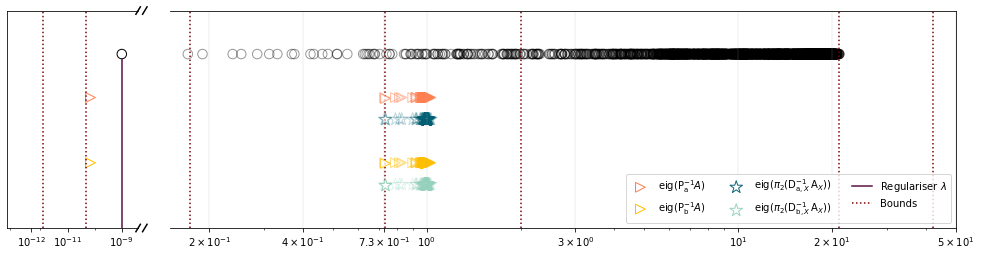

In [818]:
# Plot of spectra
fig, ax = plt.subplots(1, 2, sharey=True, facecolor='w', figsize=(17,4), width_ratios = [1/7, 1-1/7])

# plot the same data on both axes
ax[0].scatter(λ, [1.4], s = 90, alpha = 1, marker = 'o', 
            edgecolors='black', facecolors='none')
ax[0].scatter(Pₐ_Spectrum[0], [1], s = 95, alpha = 1, marker = '>', 
            color='#FF7F50', facecolors='none')
ax[0].scatter(Pᵦ_Spectrum[0], [0.4], s = 95, alpha = 1, marker = '>', 
            color='#FFBF00', facecolors='none')


# Capture label
ax[1].scatter(Pₐ_Spectrum[0], [1], s = 95, alpha = 1, marker = '>', 
              color='#FF7F50', facecolors='none', label='$\mathrm{eig}(\mathsf{P}_{\mathsf{a}}^{-1}A)$')
ax[1].scatter(Pᵦ_Spectrum[0], [0.25], s = 95, alpha = 1, marker = '>', 
              color='#FFBF00', facecolors='none', label='$\mathrm{eig}(\mathsf{P}_{\mathsf{b}}^{-1}A)$')
ax[1].scatter(λ, [0.85], s = 175, alpha = 0.95, marker = '*', 
            color='#005f73', facecolors='none', label='$\mathrm{eig}( \pi_2 ( \mathsf{D}_{\mathsf{a},X}^{-1} \, \mathsf{A}_{X}) )$')
ax[1].scatter(λ, [0.25], s = 175, alpha = 0.95, marker = '*', 
            color='#94d2bd', facecolors='none', label='$\mathrm{eig}( \pi_2 ( \mathsf{D}_{\mathsf{b},X}^{-1} \, \mathsf{A}_{X}) )$')

#
ax[1].scatter(Exact_Spectrum[1:] + λ, [1.4]*(nm-1), s = 90, alpha = 0.4, marker = 'o', 
            edgecolors='black', facecolors='none')
ax[1].scatter(Pₐ_Spectrum, [1]*nm, s = 95, alpha = 0.5, marker = '>', 
            color='#FF7F50', facecolors='none')
ax[1].scatter(Pᵦ_Spectrum, [0.4]*nm, s = 95, alpha = 0.5, marker = '>', 
            color='#FFBF00', facecolors='none')

ax[1].scatter(Dₐ_Spectrum, [0.8]*(nm-1), s = 175, alpha = 0.25, marker = '*', 
            color='#005f73', facecolors='none')
ax[1].scatter(Dᵦ_Spectrum, [0.2]*(nm-1), s = 175, alpha = 0.25, marker = '*', 
            color='#94d2bd', facecolors='none')


ax[0].axvline(x=λ, ymax = 1.05*(1.35+0.5)/2.5, color='xkcd:plum', linestyle='-')
ax[1].axvline(x=λ, color='xkcd:plum', linestyle='-', label='Regulariser $\lambda$')

ax[0].axvline(x=λ/(λ+μ*η.max()), color = '#780000', linestyle=':')
#ax[0].axvline(x=λ/(λ + η.min()), color = '#FF7F50', linestyle=':' )
ax[1].axvline(x=μ * 1*(η).max(), color='#780000', linestyle=':')
ax[1].axvline(x=μ * 2*(η).max(), color='#780000', linestyle=':')
ax[1].axvline(x=(nm/(nm-1)) * μ * η.min(), color='#780000', linestyle=':')
ax[0].axvline(x=μ*ANOVA[0,1:].min(), color='#780000', linestyle=':')

#plt.axhline(y= μ * 1.01*(η-1).max(), color='violet', linestyle='-', label='upper approximation')

ax[1].axvline(x=min(2.0, (nm/(nm-1))*(Whole_Spectrum[-1]/Whole_Spectrum[1]), Whole_Spectrum[-1]/η.min()), 
              color = '#780000', linestyle=':', label='Bounds')
ax[1].axvline(x=Pₐ_Spectrum[1] - λ/(λ + μ*η.min()), color = '#780000', linestyle=':' )
#ax[1].axvline(x=μ * 1*(η).max() * diag_Pₐ.min(), color = '#FEBA4F', linestyle=':' )
#ax[1].axvline(x=λ/(λ + η.min()), color = '#FF7F50', linestyle=':', label='$\min\,\Sigma(\mathsf{P}_{\mathsf{a}}^{-1}A)$ bounds')


# Define domain of each part
ax[0].set_xlim(-1e-13, 4e-9)
ax[1].set_xlim(1.5e-1, 5e+1)
plt.ylim(-0.2, 1.8)


# hide the spines between ax[0] and ax[1]
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].tick_params(labelleft=False, left=False)
ax[1].tick_params(labelleft=False, left=False)

#plt.xscale('log')
ax[0].set_xscale('symlog', linthresh= 1e-12)
ax[1].set_xscale('log')


# Diagonal lines
b_d = .017  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-b_d, 1+b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1-b_d, 1+b_d), (-b_d, +b_d), **kwargs)

ax[0].plot((1+2*b_d, 1+4*b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1+2*b_d, 1+4*b_d), (-b_d, +b_d), **kwargs)

# Adjust spacing between the two plots
plt.subplots_adjust(wspace=0.07)

# Add grid lines
plt.grid('on', which = 'major', linewidth = 0.2)
ax[1].yaxis.grid(False)

#ax_base = [-1,-1, 0,0,1,1,1]
#ax_val  = [ 2, 4, 1,3,1,2,5]
# Add more ticks in x-axis
ax_base = [-1,-1, -1, 0,0,1,1,1]  #[-1,-1,-1, 0]
ax_val  = [ 2, 4,7.3, 1,3,1,2,5]  #[ 7.5, 8, 9, 1]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
plt.xticks(ax_loc, ax_lbl )
ax[1].set_xticks(ax_loc, ax_lbl)

ax[0].set_xticks([7e-13, 1e-11, 1e-9], 
                 [plt.Text(1e-12,0, '$\\mathdefault{ 10^{-12} }$'), 
                  plt.Text(1e-11, 0, '$\\mathdefault{ 10^{-11} }$'), plt.Text(1e-9, 0, '$\\mathdefault{ 10^{-9} }$')])

# Stronger marker
ax[1].scatter(Pₐ_Spectrum[1], [1], s = 95, alpha = 0.7, marker = '>', color='#FF7F50', facecolors='w', zorder=3)
ax[1].scatter(Pᵦ_Spectrum[1], [0.4], s = 95, alpha = 0.8, marker = '>', color='#FFBF00', facecolors='w', zorder=3)
ax[1].scatter(Dₐ_Spectrum[0], [0.8], s = 175, alpha = 0.5, marker = '*', color='#005f73', facecolors='w', zorder=3)
ax[1].scatter(Dᵦ_Spectrum[0], [0.2], s = 175, alpha = 1, marker = '*', color='#94d2bd', facecolors='w', zorder=3)

# Present legend
ax[1].legend(loc='lower right', ncols = 3)

fig.savefig('Eigs_Diagonal_Precs_Proj_a[2].pdf', bbox_inches='tight', pad_inches=0)
plt.show()

---

Let's plot the spectra without including $\Sigma(A)$:

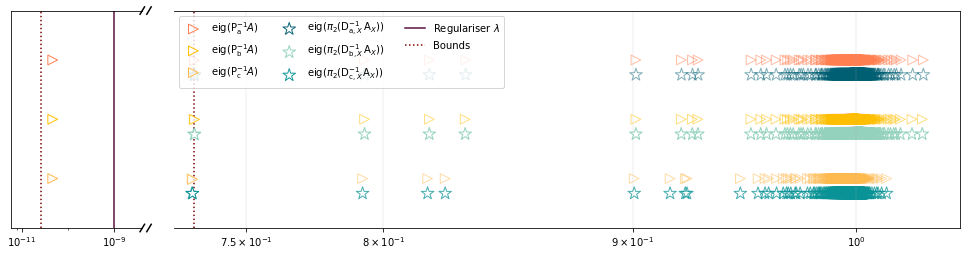

In [824]:
# Plot of spectra
fig, ax = plt.subplots(1, 2, sharey=True, facecolor='w', figsize=(17,4), width_ratios = [1/7, 1-1/7])

# plot the same data on both axes
ax[0].scatter(Pₐ_Spectrum[0], [1], s = 95, alpha = 1, marker = '>', 
            color='#FF7F50', facecolors='none')
ax[0].scatter(Pᵦ_Spectrum[0], [0.4], s = 95, alpha = 1, marker = '>', 
            color='#FFBF00', facecolors='none')
ax[0].scatter(Pᵪ_Spectrum[0], [-0.2], s = 95, alpha = 1, marker = '>', 
            color='#FEBA4F', facecolors='none')


# Capture label
ax[1].scatter(Pₐ_Spectrum[0], [1], s = 95, alpha = 1, marker = '>', 
              color='#FF7F50', facecolors='none', label='$\mathrm{eig}(\mathsf{P}_{\mathsf{a}}^{-1}A)$')
ax[1].scatter(Pᵦ_Spectrum[0], [0.25], s = 95, alpha = 1, marker = '>', 
              color='#FFBF00', facecolors='none', label='$\mathrm{eig}(\mathsf{P}_{\mathsf{b}}^{-1}A)$')
ax[1].scatter(Pᵪ_Spectrum[0], [-0.2], s = 95, alpha = 1, marker = '>', 
              color='#FEBA4F', facecolors='none', label='$\mathrm{eig}(\mathsf{P}_{\mathsf{c}}^{-1}A)$')
ax[1].scatter(λ, [0.85], s = 175, alpha = 0.95, marker = '*', 
            color='#005f73', facecolors='none', label='$\mathrm{eig}( \pi_2 ( \mathsf{D}_{\mathsf{a},X}^{-1} \, \mathsf{A}_{X}) )$')
ax[1].scatter(λ, [0.25], s = 175, alpha = 0.95, marker = '*', 
            color='#94d2bd', facecolors='none', label='$\mathrm{eig}( \pi_2 ( \mathsf{D}_{\mathsf{b},X}^{-1} \, \mathsf{A}_{X}) )$')
ax[1].scatter(λ, [-0.2], s = 175, alpha = 0.95, marker = '*', 
            color='#0a9396', facecolors='none', label='$\mathrm{eig}( \pi_2 ( \mathsf{D}_{\mathsf{c},X}^{-1} \, \mathsf{A}_{X}) )$')

#
ax[1].scatter(Pₐ_Spectrum, [1]*nm, s = 95, alpha = 0.5, marker = '>', 
            color='#FF7F50', facecolors='none')
ax[1].scatter(Pᵦ_Spectrum, [0.4]*nm, s = 95, alpha = 0.5, marker = '>', 
            color='#FFBF00', facecolors='none')
ax[1].scatter(Pᵪ_Spectrum, [-0.2]*nm, s = 95, alpha = 0.5, marker = '>', 
            color='#FEBA4F', facecolors='none')

ax[1].scatter(Dₐ_Spectrum, [0.85]*(nm-1), s = 175, alpha = 0.5, marker = '*', 
            color='#005f73', facecolors='none')
ax[1].scatter(Dᵦ_Spectrum, [0.25]*(nm-1), s = 175, alpha = 1, marker = '*', 
            color='#94d2bd', facecolors='none')
ax[1].scatter(Dᵪ_Spectrum, [-0.35]*(nm-1), s = 175, alpha = 0.75, marker = '*', 
            color='#0a9396', facecolors='none')


ax[0].axvline(x=λ, color='xkcd:plum', linestyle='-')
ax[1].axvline(x=λ, color='xkcd:plum', linestyle='-', label='Regulariser $\lambda$')

ax[0].axvline(x=λ/(λ+μ*η.max()), color = '#780000', linestyle=':')
#ax[0].axvline(x=λ/(λ + η.min()), color = '#FF7F50', linestyle=':' )

#plt.axhline(y= μ * 1.01*(η-1).max(), color='violet', linestyle='-', label='upper approximation')

ax[1].axvline(x=min(2.0, (nm/(nm-1))*(Whole_Spectrum[-1]/Whole_Spectrum[1]), Whole_Spectrum[-1]/η.min()), 
              color = '#780000', linestyle=':', label='Bounds')
ax[1].axvline(x=Pₐ_Spectrum[1] - λ/(λ + μ*η.min()), color = '#780000', linestyle=':' )
#ax[1].axvline(x=μ * 1*(η).max() * diag_Pₐ.min(), color = '#FEBA4F', linestyle=':' )
#ax[1].axvline(x=λ/(λ + η.min()), color = '#FF7F50', linestyle=':', label='$\min\,\Sigma(\mathsf{P}_{\mathsf{a}}^{-1}A)$ bounds')


# Define domain of each part
ax[0].set_xlim(-1e-11, 4e-9)
ax[1].set_xlim(7.25e-1, 1.05)
plt.ylim(-0.7, 1.5)


# hide the spines between ax[0] and ax[1]
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].tick_params(labelleft=False, left=False)
ax[1].tick_params(labelleft=False, left=False)

#plt.xscale('log')
ax[0].set_xscale('symlog', linthresh= 1e-10)
ax[1].set_xscale('log')


# Diagonal lines
b_d = .017  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-b_d, 1+b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1-b_d, 1+b_d), (-b_d, +b_d), **kwargs)

ax[0].plot((1+2*b_d, 1+4*b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1+2*b_d, 1+4*b_d), (-b_d, +b_d), **kwargs)

# Adjust spacing between the two plots
plt.subplots_adjust(wspace=0.07)

# Add grid lines
plt.grid('on', which = 'major', linewidth = 0.2)
ax[1].yaxis.grid(False)

# Add more ticks in x-axis
ax_base = [-1,-1,-1, 0]
ax_val  = [ 7.5, 8, 9, 1]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
plt.xticks(ax_loc, ax_lbl )
ax[1].set_xticks(ax_loc, ax_lbl)

ax[0].set_xticks([1e-11, 1e-9], 
                 [plt.Text(1e-11, 0, '$\\mathdefault{ 10^{-11} }$'), plt.Text(1e-9, 0, '$\\mathdefault{ 10^{-9} }$')])

# Stronger marker
ax[1].scatter(Pₐ_Spectrum[1], [1], s = 95, alpha = 0.7, marker = '>', color='#FF7F50', facecolors='w', zorder=3)
ax[1].scatter(Pᵦ_Spectrum[1], [0.4], s = 95, alpha = 0.8, marker = '>', color='#FFBF00', facecolors='w', zorder=3)
ax[1].scatter(Pᵪ_Spectrum[1], [-0.2], s = 95, alpha = 0.8, marker = '>', color='#FEBA4F', facecolors='w', zorder=3)
ax[1].scatter(Dₐ_Spectrum[0], [0.85], s = 175, alpha = 0.5, marker = '*', color='#005f73', facecolors='w', zorder=3)
ax[1].scatter(Dᵦ_Spectrum[0], [0.25], s = 175, alpha = 1, marker = '*', color='#94d2bd', facecolors='w', zorder=3)
ax[1].scatter(Dᵪ_Spectrum[0], [-0.35], s = 175, alpha = 1, marker = '*', color='#0a9396', facecolors='w', zorder=3)

# Present legend
ax[1].legend(loc='upper left', ncols = 3)

#fig.savefig('Eigs_Diagonal_Precs_Proj_b[3].pdf', bbox_inches='tight', pad_inches=0)
plt.show()

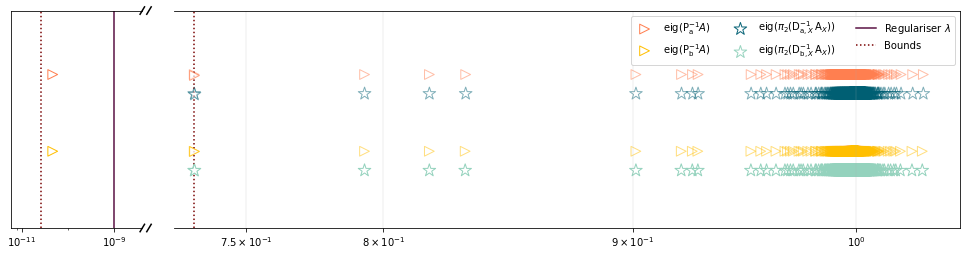

In [826]:
# Plot of spectra
fig, ax = plt.subplots(1, 2, sharey=True, facecolor='w', figsize=(17,4), width_ratios = [1/7, 1-1/7])

# plot the same data on both axes
ax[0].scatter(Pₐ_Spectrum[0], [1], s = 95, alpha = 1, marker = '>', 
            color='#FF7F50', facecolors='none')
ax[0].scatter(Pᵦ_Spectrum[0], [0.4], s = 95, alpha = 1, marker = '>', 
            color='#FFBF00', facecolors='none')


# Capture label
ax[1].scatter(Pₐ_Spectrum[0], [1], s = 95, alpha = 1, marker = '>', 
              color='#FF7F50', facecolors='none', label='$\mathrm{eig}(\mathsf{P}_{\mathsf{a}}^{-1}A)$')
ax[1].scatter(Pᵦ_Spectrum[0], [0.25], s = 95, alpha = 1, marker = '>', 
              color='#FFBF00', facecolors='none', label='$\mathrm{eig}(\mathsf{P}_{\mathsf{b}}^{-1}A)$')
ax[1].scatter(λ, [0.85], s = 175, alpha = 0.95, marker = '*', 
            color='#005f73', facecolors='none', label='$\mathrm{eig}( \pi_2 ( \mathsf{D}_{\mathsf{a},X}^{-1} \, \mathsf{A}_{X}) )$')
ax[1].scatter(λ, [0.25], s = 175, alpha = 0.95, marker = '*', 
            color='#94d2bd', facecolors='none', label='$\mathrm{eig}( \pi_2 ( \mathsf{D}_{\mathsf{b},X}^{-1} \, \mathsf{A}_{X}) )$')

#
ax[1].scatter(Pₐ_Spectrum, [1]*nm, s = 95, alpha = 0.5, marker = '>', 
            color='#FF7F50', facecolors='none')
ax[1].scatter(Pᵦ_Spectrum, [0.4]*nm, s = 95, alpha = 0.5, marker = '>', 
            color='#FFBF00', facecolors='none')

ax[1].scatter(Dₐ_Spectrum, [0.85]*(nm-1), s = 175, alpha = 0.5, marker = '*', 
            color='#005f73', facecolors='none')
ax[1].scatter(Dᵦ_Spectrum, [0.25]*(nm-1), s = 175, alpha = 1, marker = '*', 
            color='#94d2bd', facecolors='none')


ax[0].axvline(x=λ, color='xkcd:plum', linestyle='-')
ax[1].axvline(x=λ, color='xkcd:plum', linestyle='-', label='Regulariser $\lambda$')

ax[0].axvline(x=λ/(λ+μ*η.max()), color = '#780000', linestyle=':')
#ax[0].axvline(x=λ/(λ + η.min()), color = '#FF7F50', linestyle=':' )

#plt.axhline(y= μ * 1.01*(η-1).max(), color='violet', linestyle='-', label='upper approximation')

ax[1].axvline(x=min(2.0, (nm/(nm-1))*(Whole_Spectrum[-1]/Whole_Spectrum[1]), Whole_Spectrum[-1]/η.min()), 
              color = '#780000', linestyle=':', label='Bounds')
ax[1].axvline(x=Pₐ_Spectrum[1] - λ/(λ + μ*η.min()), color = '#780000', linestyle=':' )
#ax[1].axvline(x=μ * 1*(η).max() * diag_Pₐ.min(), color = '#FEBA4F', linestyle=':' )
#ax[1].axvline(x=λ/(λ + η.min()), color = '#FF7F50', linestyle=':', label='$\min\,\Sigma(\mathsf{P}_{\mathsf{a}}^{-1}A)$ bounds')


# Define domain of each part
ax[0].set_xlim(-1e-11, 4e-9)
ax[1].set_xlim(7.25e-1, 1.05)
plt.ylim(-0.2, 1.5)


# hide the spines between ax[0] and ax[1]
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].tick_params(labelleft=False, left=False)
ax[1].tick_params(labelleft=False, left=False)

#plt.xscale('log')
ax[0].set_xscale('symlog', linthresh= 1e-10)
ax[1].set_xscale('log')


# Diagonal lines
b_d = .017  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-b_d, 1+b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1-b_d, 1+b_d), (-b_d, +b_d), **kwargs)

ax[0].plot((1+2*b_d, 1+4*b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1+2*b_d, 1+4*b_d), (-b_d, +b_d), **kwargs)

# Adjust spacing between the two plots
plt.subplots_adjust(wspace=0.07)

# Add grid lines
plt.grid('on', which = 'major', linewidth = 0.2)
ax[1].yaxis.grid(False)

# Add more ticks in x-axis
ax_base = [-1,-1,-1, 0]
ax_val  = [ 7.5, 8, 9, 1]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
plt.xticks(ax_loc, ax_lbl )
ax[1].set_xticks(ax_loc, ax_lbl)

ax[0].set_xticks([1e-11, 1e-9], 
                 [plt.Text(1e-11, 0, '$\\mathdefault{ 10^{-11} }$'), plt.Text(1e-9, 0, '$\\mathdefault{ 10^{-9} }$')])

# Stronger marker
ax[1].scatter(Pₐ_Spectrum[1], [1], s = 95, alpha = 0.7, marker = '>', color='#FF7F50', facecolors='w', zorder=3)
ax[1].scatter(Pᵦ_Spectrum[1], [0.4], s = 95, alpha = 0.8, marker = '>', color='#FFBF00', facecolors='w', zorder=3)
ax[1].scatter(Dₐ_Spectrum[0], [0.85], s = 175, alpha = 0.5, marker = '*', color='#005f73', facecolors='w', zorder=3)
ax[1].scatter(Dᵦ_Spectrum[0], [0.25], s = 175, alpha = 1, marker = '*', color='#94d2bd', facecolors='w', zorder=3)

# Present legend
ax[1].legend(loc='upper right', ncols = 3)

fig.savefig('Eigs_Diagonal_Precs_Proj_b[2].pdf', bbox_inches='tight', pad_inches=0)
plt.show()

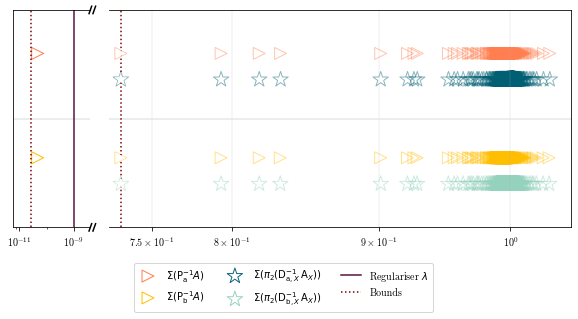

In [1062]:
# Plot of spectra
fig, ax = plt.subplots(1, 2, sharey=True, facecolor='w', figsize=(10,4), width_ratios = [1/7, 1-1/7])
m_s_a = 1.5*95        # Marker size
m_s_b = 1.5*175

# plot the same data on both axes
ax[0].scatter(Pₐ_Spectrum[0], [1], s = m_s_a, alpha = 1, marker = '>', 
            color='#FF7F50', facecolors='none')
ax[0].scatter(Pᵦ_Spectrum[0], [0.4], s = m_s_a, alpha = 1, marker = '>', 
            color='#FFBF00', facecolors='none')


# Capture label
ax[1].scatter(Pₐ_Spectrum[0], [1], s = m_s_a, alpha = 1, marker = '>', 
              color='#FF7F50', facecolors='none', label='$\Sigma(\mathsf{P}_{\mathsf{a}}^{-1}A)$')
ax[1].scatter(Pᵦ_Spectrum[0], [0.25], s = m_s_a, alpha = 1, marker = '>', 
              color='#FFBF00', facecolors='none', label='$\Sigma(\mathsf{P}_{\mathsf{b}}^{-1}A)$')
ax[1].scatter(λ, [0.85], s = m_s_b, alpha = 0.95, marker = '*', 
            color='#005f73', facecolors='none', label='$\Sigma( \pi_2 ( \mathsf{D}_{\mathsf{a},X}^{-1} \, \mathsf{A}_{X}) )$')
ax[1].scatter(λ, [0.25], s = m_s_b, alpha = 0.95, marker = '*', 
            color='#94d2bd', facecolors='none', label='$\Sigma( \pi_2 ( \mathsf{D}_{\mathsf{b},X}^{-1} \, \mathsf{A}_{X}) )$')

#
ax[1].scatter(Pₐ_Spectrum, [1]*nm, s = m_s_a, alpha = 0.45, marker = '>', 
            color='#FF7F50', facecolors='none')
ax[1].scatter(Pᵦ_Spectrum, [0.4]*nm, s = m_s_a, alpha = 0.45, marker = '>', 
            color='#FFBF00', facecolors='none')

ax[1].scatter(Dₐ_Spectrum, [0.85]*(nm-1), s = m_s_b, alpha = 0.45, marker = '*', 
            color='#005f73', facecolors='none')
ax[1].scatter(Dᵦ_Spectrum, [0.25]*(nm-1), s = m_s_b, alpha = 0.45, marker = '*', 
            color='#94d2bd', facecolors='none')

ax[0].axhline(0.5 * (0.85 + 0.4), color=(0.9, 0.9, 0.9), linestyle='-')
ax[1].axhline(0.5 * (0.85 + 0.4), color=(0.9, 0.9, 0.9), linestyle='-')


ax[0].axvline(x=λ, color='xkcd:plum', linestyle='-')
ax[1].axvline(x=λ, color='xkcd:plum', linestyle='-', label='Regulariser $\lambda$')

ax[0].axvline(x=λ/(λ+μ*η.max()), color = '#780000', linestyle=':')
#ax[0].axvline(x=λ/(λ + η.min()), color = '#FF7F50', linestyle=':' )

#plt.axhline(y= μ * 1.01*(η-1).max(), color='violet', linestyle='-', label='upper approximation')

ax[1].axvline(x=min(2.0, (nm/(nm-1))*(Whole_Spectrum[-1]/Whole_Spectrum[1]), Whole_Spectrum[-1]/η.min()), 
              color = '#780000', linestyle=':', label='Bounds')
ax[1].axvline(x=Pₐ_Spectrum[1] - λ/(λ + μ*η.min()), color = '#780000', linestyle=':' )
#ax[1].axvline(x=μ * 1*(η).max() * diag_Pₐ.min(), color = '#FEBA4F', linestyle=':' )
#ax[1].axvline(x=λ/(λ + η.min()), color = '#FF7F50', linestyle=':', label='$\min\,\Sigma(\mathsf{P}_{\mathsf{a}}^{-1}A)$ bounds')


# Define domain of each part
ax[0].set_xlim(-1e-11, 4e-9)
ax[1].set_xlim(7.25e-1, 1.05)
#plt.ylim(-0.2, 1.5)
plt.ylim(0, 1.25)


# hide the spines between ax[0] and ax[1]
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].tick_params(labelleft=False, left=False)
ax[1].tick_params(labelleft=False, left=False)

#plt.xscale('log')
ax[0].set_xscale('symlog', linthresh= 1e-10)
ax[1].set_xscale('log')


# Diagonal lines
b_d = .017  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-b_d, 1+b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1-b_d, 1+b_d), (-b_d, +b_d), **kwargs)

ax[0].plot((1+2*b_d, 1+4*b_d), (1-b_d, 1+b_d), **kwargs)
ax[0].plot((1+2*b_d, 1+4*b_d), (-b_d, +b_d), **kwargs)

# Adjust spacing between the two plots
plt.subplots_adjust(wspace=0.07)

# Add grid lines
plt.grid('on', which = 'major', linewidth = 0.2)
ax[1].yaxis.grid(False)

# Add more ticks in x-axis
ax_base = [-1,-1,-1, 0]
ax_val  = [ 7.5, 8, 9, 1]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
plt.xticks(ax_loc, ax_lbl )
ax[1].set_xticks(ax_loc, ax_lbl, fontname='CMR10')

ax[0].set_xticks([1e-11, 1e-9], 
                 [plt.Text(1e-11, 0, '$\\mathdefault{ 10^{-11} }$'), plt.Text(1e-9, 0, '$\\mathdefault{ 10^{-9} }$')], fontname='CMR10')

# Stronger marker
ax[1].scatter(Pₐ_Spectrum[1], [1], s = m_s_a*0.72, alpha = 1, marker = '>', color='none', facecolors='w', zorder=3)
ax[1].scatter(Pᵦ_Spectrum[1], [0.4], s = m_s_a*0.72, alpha = 1, marker = '>', color='none', facecolors='w', zorder=3)
ax[1].scatter(Dₐ_Spectrum[0], [0.85], s = m_s_b*0.72, alpha = 1, marker = '*', color='none', facecolors='w', zorder=3)
ax[1].scatter(Dᵦ_Spectrum[0], [0.25], s = m_s_b*0.72, alpha = 1, marker = '*', color='none', facecolors='w', zorder=3, )

# Present legend
#ax[1].legend(loc='upper center', ncols = 3, prop={'family': 'CMR10'})

leg_handles, leg_labels = ax[1].get_legend_handles_labels()
fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=3, bbox_transform=plt.gcf().transFigure, prop={'family': 'CMR10'})



fig.savefig('Eigs_Diagonal_Precs_Proj_b[2]_v2.pdf', bbox_inches='tight', pad_inches=0)

#with open('Eigs_Diagonal_Precs_Proj_b[2]_v2.pickle', 'wb') as file:
#    pl.dump(fig, file)
plt.show()

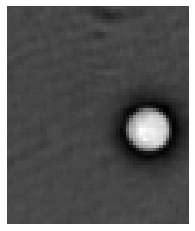

In [1072]:
plt.imshow(image, cmap='gray');    plt.axis('off');    plt.show()

In [1069]:
'{0:.2e}'.format(Pa_Spectrum[-1]/Pa_Spectrum[0]), '{0:.2e}'.format(Whole_Spectrum[-1]/1e-9)

('1.47e+10', '2.11e+10')

In [692]:
Dₐ_Spectrum[[0,-1]]

array([0.7317979 , 1.03202212])

In [697]:
Dₐ_Spectrum[0], Pₐ_Spectrum[1], (Dₐ_Spectrum[0] < Pₐ_Spectrum[1]), (Pₐ_Spectrum[1] - λ/(λ + μ*η.min()) < Dₐ_Spectrum[0])

(0.7317979012458968, 0.7317979012668301, True, True)

---

In case we need to test things again with $\mathsf{S}_X^{-1} \mathsf{A}_X$:

In [625]:
Test = (UTAU + np.diag([λ]*(nm), 0));    Test[0,:] = Test[:,0] = 0.0

In [649]:
eigvalsh(U_t_Pₐ_U.dot(Test).dot(U_t_Pₐ_U), check_finite = False)[1:]    # First eigenvalue is 0

array([0.7317979 , 0.79301162, 0.81761842, ..., 1.02123373, 1.02685022,
       1.03202212])

In [651]:
Pₐ_Spectrum[1:]

array([0.7317979 , 0.79301162, 0.81761842, ..., 1.02123373, 1.02685022,
       1.03202212])

In [652]:
Dₐ_Spectrum[1:]

array([0.79247599, 0.81738293, 0.82689169, ..., 1.02123217, 1.02684867,
       1.03202163])

---

# Eigenvalues of $A$ for different $\sigma$

$
    \varepsilon = \exp( -\sigma^{-2} r^2 ) 
    \quad\Rightarrow \quad
    \log(\varepsilon) = -\sigma^{-2} r^2
    \quad\Rightarrow \quad
    \sigma = r \big/ \sqrt{-\log(\varepsilon)}
$

In [17]:
print('Suggested range for σ: {}'.format([σᴸ, σᵁ]))

Suggested range for σ: [16.27347274188335, 25035068.717526518]


In [2213]:
print( '{0:.3e} {1:.2e} {2:.9e}'.format(σᵁ, σᵁ**-2, np.exp(-((σᵁ)**-1 * max(fᵂ) )**2 )  ))
print( '{0:.6f} {1:.2e} {2:.9e}'.format(σᴸ, σᴸ**-2, np.exp(-((σᴸ)**-1 * min(fᵂ) )**2 )  ))

2.504e+07 1.60e-15 9.999999999e-01
16.273473 3.78e-03 1.648058472e-103


I ran an eigentest for several values of $\sigma$. It was observed that as $\sigma$ became larger, above $1\,500$, the resulting non-minimal eigenvalues were clustered around $\mu n$ (which is expected by the action of $\sigma$). In a similar fashion, as $\sigma$ became smaller, below $10$, the non-minimal eigenvalues became clustered now around $0$, with many eigenvalues having values below machine precision, which resulted in some very small negative values being reported by error. Our working range above can then be refined as follows:

1. Define $f_\mathsf{B} = \Big\{ \big\| \max_{i\in [1:n]} (f^{W_\ell})_{i,[1:3]} - \min_{i\in [1:n]} (f^{W_\ell})_{i,[1:3]} \big\| \Big\}_{\ell \in [1:\mathsf{L}]} $.
2. Define $r_\min = \min f_\mathsf{B}$ and $r_\max = \max f_\mathsf{B}$.
3. Define a lower threshold $\varepsilon_\min \ll 1$ for the entries of $\Gamma$ and obtain $\sigma_\min = r_\max \big/ \sqrt{-\log(\varepsilon_\min)}$.
4. Define an upper threshold $\varepsilon_\max \ll 1$ for the entries of $\Gamma$ and obtain $\sigma_\max = r_\min \big/ \sqrt{-\log(1-\varepsilon_\max)}$.

In any case, we are only interested in our defined working range, as the nonlocal operator will only then capture relevant features of the underlying image. We later found that the range $[10,1500]$ seemed to fit well in our computations.

In [2512]:
ε = 3e-2
σᵁ = min(fᵂ)/np.sqrt(-np.log1p(-3e-2))
print( '{0:.0e}    {1:.3e} {2:.2e} {3:.9e}'.format(ε, σᵁ, σᵁ**-2, np.exp(-((σᵁ)**-1 * max(fᵂ) )**2 )  ))
ε = 1e-308
σᴸ = max(fᵂ)/np.sqrt(-np.log(ε))
print( '{0:.0e}   {1:.6f} {2:.2e} {3:.9e}'.format(ε, σᴸ, σᴸ**-2, np.exp(-((σᴸ)**-1 * min(fᵂ) )**2 )  ))

3e-02    1.434e+03 4.86e-07 9.126730000e-01
1e-308   16.282692 3.77e-03 2.154434690e-103


The upper bound requires a flexible value of $\varepsilon$. This suggests that the mid eigenvalues of the nonlocal kernel get closer to the upper bound $\mu n$ very quickly, until the linear behaviour kicks in.

The lower bound instead suggests that the threshold is tied to the numerical precision of $\log$. Values of $\varepsilon_\min$  below the smallest normal IEEE floating-point number cannot be used in the `log` function unless we require a larger precision.

In [2516]:
print(np.finfo(np.float64))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
smallest_normal = 2.2250738585072014e-308   smallest_subnormal = 4.9406564584124654e-324
---------------------------------------------------------------



---

## Little examples:

If we obtained a scree plot of the eigenvalues, we would observe the following: If $\sigma$ is large, then many eigenvalues are _linearly_ close to $\mu n$, and, in contrast, if $\sigma$ is small, then many eigenvalues are _linearly_ close to $0$.

Large $\sigma$:

In [2137]:
ANOVA = Full_W(1.6e+7);    np.fill_diagonal(ANOVA, 0.0);    η = ANOVA.dot( ones(nm) )
exact_s = eigvalsh( (μ * ( np.diag(η) - ANOVA )), check_finite='false')
del ANOVA
print(describe(exact_s[1:]))
print(describe(exact_s[exact_s > (1-1e-5)*(nm*μ)]))

DescribeResult(nobs=3629, minmax=(72.59999998769774, 72.59999999883561), mean=72.59999999802783, variance=2.3375087956154547e-18, skewness=-3.8585405118949874, kurtosis=16.671207120809886)
DescribeResult(nobs=3629, minmax=(72.59999998769774, 72.59999999883561), mean=72.59999999802783, variance=2.3375087956154547e-18, skewness=-3.8585405118949874, kurtosis=16.671207120809886)


In [2138]:
ANOVA = Full_W(5e+4);    np.fill_diagonal(ANOVA, 0.0);    η = ANOVA.dot( ones(nm) )
exact_s = eigvalsh( (μ * ( np.diag(η) - ANOVA )), check_finite='false')
del ANOVA
print(describe(exact_s[1:]))
print(describe(exact_s[exact_s > (1-1e-5)*(nm*μ)]))

DescribeResult(nobs=3629, minmax=(72.59874026061144, 72.59988077056114), mean=72.59979804939158, variance=2.451009812291876e-08, skewness=-3.8585092329294293, kurtosis=16.67100968329441)
DescribeResult(nobs=3528, minmax=(72.59927638989963, 72.59988077056114), mean=72.59981959375386, variance=7.895890433195927e-09, skewness=-2.974708643230683, kurtosis=10.92084993786578)


In [2147]:
ANOVA = Full_W(2e+4);    np.fill_diagonal(ANOVA, 0.0);    η = ANOVA.dot( ones(nm) )
exact_s = eigvalsh( (μ * ( np.diag(η) - ANOVA )), check_finite='false')
del ANOVA
print(describe(exact_s[1:]))
print(describe(exact_s[exact_s > (1-1e-4)*(nm*μ)]))

DescribeResult(nobs=3629, minmax=(72.59212708748012, 72.59925482841871), mean=72.59873783934987, variance=9.573275010851504e-07, skewness=-3.858449733059046, kurtosis=16.67048860342221)
DescribeResult(nobs=3618, minmax=(72.59274148627658, 72.59925482841871), mean=72.59875696028546, variance=8.39489366114562e-07, skewness=-3.7896016845195923, kurtosis=16.18615660308006)


Small $\sigma$:

In [2184]:
ANOVA = Full_W(1);    np.fill_diagonal(ANOVA, 0.0);    η = ANOVA.dot( ones(nm) )
exact_s = eigvalsh( (μ * ( np.diag(η) - ANOVA )), check_finite='false')
del ANOVA
print(describe(exact_s[1:]))
print(describe(exact_s[exact_s > 1e-4]))

DescribeResult(nobs=3629, minmax=(1.5601549141625898e-07, 0.6815517944251142), mean=0.10644380675807291, variance=0.017679961236662246, skewness=1.7871301054132007, kurtosis=2.328387463167413)
DescribeResult(nobs=3616, minmax=(0.00011279374545531033, 0.6815517944251142), mean=0.10682630823848764, variance=0.017702687057469003, skewness=1.783318436645991, kurtosis=2.3118030525717135)


In [2186]:
ANOVA = Full_W(1e-1);    np.fill_diagonal(ANOVA, 0.0);    η = ANOVA.dot( ones(nm) )
exact_s = eigvalsh( (μ * ( np.diag(η) - ANOVA )), check_finite='false')
del ANOVA
print(describe(exact_s[1:]))
print(describe(exact_s[exact_s > 1e-4]))

DescribeResult(nobs=3629, minmax=(-5.101278624128542e-18, 0.6603061253988584), mean=0.07163957792116939, variance=0.017479055853540704, skewness=1.8841450415420131, kurtosis=2.606731224195725)
DescribeResult(nobs=3455, minmax=(0.00010099002416822656, 0.6603061253988584), mean=0.07524685144889254, variance=0.018088117462358284, skewness=1.807078054054751, kurtosis=2.2970576642395653)


## Working range tests

In [1301]:
Σ = np.logspace(0, 2.05, 20) * 13
Exact_Spectrums = np.zeros([20,nm])
k = 0
for σ in Σ:
    print('{0:.2e}: '.format(σ), end ='')
    start = time.time()
    ANOVA = Full_W(σ);    np.fill_diagonal(ANOVA, 0.0);    η = ANOVA.dot( ones(nm) )
    Exact_Spectrums[k,:] = eigvalsh( (μ * ( np.diag(η) - ANOVA )), check_finite='false')
    end = time.time()
    del ANOVA
    k +=1
    print('{0:.2f} '.format(end-start))

1.30e+01: 8.47 
1.67e+01: 8.09 
2.14e+01: 8.26 
2.74e+01: 8.18 
3.51e+01: 8.33 
4.50e+01: 8.93 
5.77e+01: 9.08 
7.40e+01: 9.33 
9.49e+01: 9.03 
1.22e+02: 9.26 
1.56e+02: 8.94 
2.00e+02: 8.21 
2.56e+02: 9.45 
3.29e+02: 9.71 
4.21e+02: 9.09 
5.40e+02: 8.57 
6.92e+02: 8.21 
8.87e+02: 8.97 
1.14e+03: 9.41 
1.46e+03: 8.74 


In [1302]:
np.clip(Exact_Spectrums, 0.0, nm*μ, out = Exact_Spectrums);    Exact_Spectrums[:,0] = 0.0

Now we can plot everything:

In [1438]:
from matplotlib.colors import to_hex, to_rgb

In [1439]:
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1 = np.array(to_rgb(c1))
    c2 = np.array(to_rgb(c2))
    return to_hex((1-mix)*c1 + mix*c2)

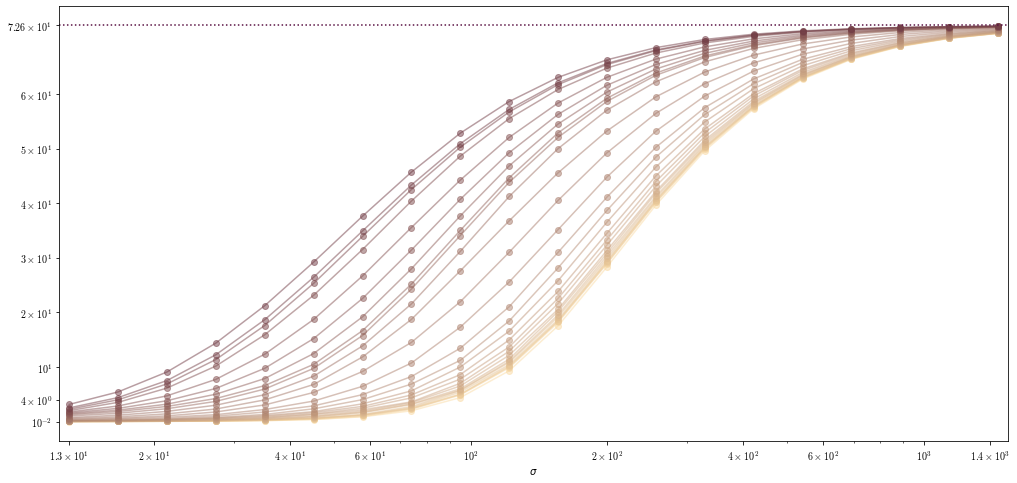

In [1647]:
# All eigs
fig, ax = plt.subplots(1,1, facecolor='w', figsize=(17,8))

Base_Range  = np.unique(np.logspace(0,np.log10(nm), 30).astype(int))
Index_Range = Base_Range    #np.unique(np.sort(np.r_[nm - Base_Range, Base_Range]))
kk=1
for k in Index_Range:
    plt.plot(Σ, Exact_Spectrums[:,k]+1e-9 , marker='o', alpha=0.5, color = colorFader('#ffe1a8','#723d46',kk/Index_Range.size) );
    kk +=1

plt.axhline(y= μ * nm, color='xkcd:plum', linestyle=':')
    
# Set scales
ax.set_xscale('log')
#ax.set_yscale('log')

# Add more ticks in x-axis
ax_base = [1,1,1,1, 2,2,2,2, 3,3]
ax_val  = [ 1.3, 2,4,6,  1, 2,4,6, 1,1.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax.set_xticks(ax_loc, ax_lbl, fontname='CMR10')

# Add more ticks in y-axis
ax_base = [-2,   0,  1,1,1,1,1,1, 1]
ax_val  = [ 1, 4, 1,2,3,4,5,6, 7.26]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax.set_yticks(ax_loc, ax_lbl, fontname='CMR10')

#plt.axhline(y= Exact_Spectrums[:,1:].min(), color='xkcd:plum', linestyle=':')


ax.set_xlabel('$\sigma$', fontname='CMR10');
ax.set_xlim(Σ[0]*0.95, Σ[-1]*1.05);

#ax.set_yscale('symlog', linthresh= 40)


#fig.savefig('Eigs_Diagonal_Precs_Proj_b[2]_v2.pdf', bbox_inches='tight', pad_inches=0)

#with open('Eigs_Diagonal_Precs_Proj_b[2]_v2.pickle', 'wb') as file:
#    pl.dump(fig, file)
plt.show()

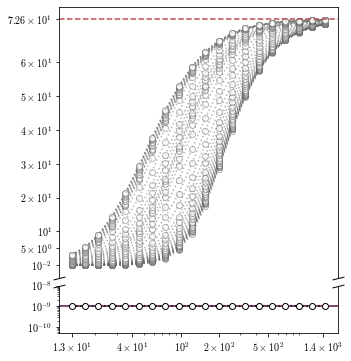

In [2043]:
# A
fig = plt.figure(figsize=(5, 6))
gs = GridSpec(2, 1, height_ratios=[85, 15], hspace=0.05, figure=fig)

# Create two axes
ax = fig.add_subplot(gs[0]), fig.add_subplot(gs[1])

fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# Select indices to sample from (nm is large)
Base_Range  = np.unique(np.logspace(0,np.log10(nm), 40).astype(int))
Index_Range = np.unique(np.sort(np.r_[nm - np.unique(np.logspace(0,np.log10(nm), 10).astype(int)), Base_Range]))
#Index_Range = np.arange(1,nm, 20)

# –––––––– Plotting –––––––– #
kk=1
for k in Index_Range:
    ax[0].plot(Σ, Exact_Spectrums[:,k]+λ, linestyle=':', marker='o', alpha=0.5, 
               color = colorFader('#5A5A5A','#787878',kk/Index_Range.size), markerfacecolor = 'white' );
    kk +=1
ax[0].axhline(y= μ * nm, color='#C14953', linestyle='--')

# The second panel contains the smallest eigenvalues
ax[1].axhline(y = λ, color='xkcd:plum', linestyle='-')        # Add line at λ
ax[1].plot(Σ, λ * np.ones_like(Σ), linestyle=':', marker='o', alpha=1, color = 'black', markerfacecolor='white' );
ax[1].set_ylim(5e-11, 3e-9)
#ax[1].set_xlim(10.266995042198511, 1846.8998767182368)

# Set scales
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#ax[0].set_yscale('function', functions=(transform, inverse_transform))
#ax[0].set_yscale('log')
ax[1].set_yscale('log')


# –––––––– Ticks –––––––– #
# Add more ticks in x-axis — Second panel
ax_base = [1,1, 2,2,2, 3]
ax_val  = [ 1.3, 4,  1, 2,5, 1.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_xticks(ax_loc, ax_lbl, fontname='CMR10')

# Add more ticks in y-axis — First panel
ax_base = [-2,   0,  1,1,1,1,1,1, 1]
ax_val  = [ 1, 5, 1,2,3,4,5,6, 7.26]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[0].set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis — Second panel
ax_base = [-10,-9,-8]
ax_val  = [1,1,1]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_yticks(ax_loc, ax_lbl, fontname='CMR10');


# –––––––– Decorators –––––––– #
# hide the spines between ax and ax2
ax[0].tick_params(axis="x", which="both", length=0)
ax[0].xaxis.set_ticks([])
ax[0].spines['bottom'].set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].xaxis.tick_bottom()

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)

# –––––––– Store –––––––– #
fig.savefig('Eigs_A_Sigma.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

I noticed that an upper bound could be obtained by rounding up a couple of parameters of the following fitting:

```MATLAB
X = np.log(Σ); Y = (Exact_Spectrums[:,k] + 1e-9)/(nm*μ)

Sigmoidal Curve Fit (logistic)
f(x) = a/(1 + exp(-b*(x-c)))

Coefficients and 95% Confidence Bounds
     Value     Lower     Upper  
a    0.9968    0.9913    1.0023
b    1.9333    1.8860    1.9807
c    4.0280    4.0135    4.0425

Goodness of Fit
             Value  
SSE         0.0007 
R-square    0.9997 
DFE         17.0000
Adj R-sq    0.9997 
RMSE        0.0064 
```

By rounding up, we obtain the following curve:
\begin{align*}
    B(\sigma) = \frac{n\mu}{1 +  e^8 \sigma^{-2}} + \lambda
\end{align*}

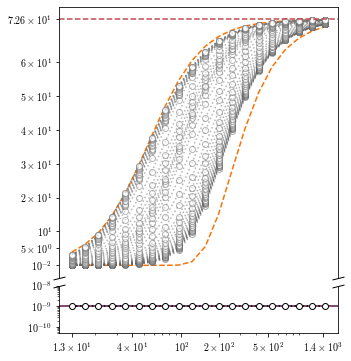

In [2523]:
# A - with bounds
fig = plt.figure(figsize=(5, 6))
gs = GridSpec(2, 1, height_ratios=[85, 15], hspace=0.05, figure=fig)

# Create two axes
ax = fig.add_subplot(gs[0]), fig.add_subplot(gs[1])

fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# Select indices to sample from (nm is large)
Base_Range  = np.unique(np.logspace(0,np.log10(nm), 40).astype(int))
Index_Range = np.unique(np.sort(np.r_[nm - np.unique(np.logspace(0,np.log10(nm), 10).astype(int)), Base_Range]))
#Index_Range = np.arange(1,nm, 20)

# –––––––– Plotting –––––––– #
kk=1
ax[0].plot(Σ, nm*μ* np.exp(-( min(fᵂ) /Σ)**2) + λ, color='xkcd:orange', linestyle='--' )
ax[0].plot(Σ, (nm*μ)/ (1 + (Σ**-2) * np.exp(8)), color='xkcd:orange', linestyle='--' )
for k in Index_Range:
    ax[0].plot(Σ, Exact_Spectrums[:,k]+λ, linestyle=':', marker='o', alpha=0.5, 
               color = colorFader('#5A5A5A','#787878',kk/Index_Range.size), markerfacecolor = 'white' );
    kk +=1
ax[0].axhline(y= μ * nm, color='#C14953', linestyle='--')

# The second panel contains the smallest eigenvalues
ax[1].axhline(y = λ, color='xkcd:plum', linestyle='-')        # Add line at λ
ax[1].plot(Σ, λ * np.ones_like(Σ), linestyle=':', marker='o', alpha=1, color = 'black', markerfacecolor='white' );
ax[1].set_ylim(5e-11, 3e-9)
#ax[1].set_xlim(10.266995042198511, 1846.8998767182368)

# Set scales
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#ax[0].set_yscale('function', functions=(transform, inverse_transform))
#ax[0].set_yscale('log')
ax[1].set_yscale('log')


# –––––––– Ticks –––––––– #
# Add more ticks in x-axis — Second panel
ax_base = [1,1, 2,2,2, 3]
ax_val  = [ 1.3, 4,  1, 2,5, 1.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_xticks(ax_loc, ax_lbl, fontname='CMR10')

# Add more ticks in y-axis — First panel
ax_base = [-2,   0,  1,1,1,1,1,1, 1]
ax_val  = [ 1, 5, 1,2,3,4,5,6, 7.26]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[0].set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis — Second panel
ax_base = [-10,-9,-8]
ax_val  = [1,1,1]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_yticks(ax_loc, ax_lbl, fontname='CMR10');


# –––––––– Decorators –––––––– #
# hide the spines between ax and ax2
ax[0].tick_params(axis="x", which="both", length=0)
ax[0].xaxis.set_ticks([])
ax[0].spines['bottom'].set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].xaxis.tick_bottom()

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)

# –––––––– Store –––––––– #
fig.savefig('Eigs_A_Sigma_Extra.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

We can check this value with the eigenvalues we have obtained so far:

In [2531]:
np.log( ((nm * μ )/Exact_Spectrum[-1] - 1)/(35**-2) )

8.000116971684959

Why $e^8$? That is something we should test in the future.

---

Now let's also collect the eigenvalues of all preconditioned systems:

In [1677]:
# Pre allocate memory
Prec_Spectrums_P_a, Prec_Spectrums_P_b, Prec_Spectrums_P_c = np.zeros([3, 20,nm])
Prec_Spectrums_D_a, Prec_Spectrums_D_b, Prec_Spectrums_D_c = np.zeros([3, 20,nm-1])

Σ = np.logspace(0, 2.05, 20) * 13
k = 0
timed = 0

for σ in Σ:
    print('{0:.2e} – '.format(σ), end ='')
    # Build ANOVA base
    ANOVA = Full_W(σ);    np.fill_diagonal(ANOVA, 0.0);    η = ANOVA.dot( ones(nm) )
    # Transform ANOVA kernel to unitary base
    UTAU = (U.T).dot( μ * ( np.diag(η) - ANOVA ) ).dot(U)  # No need of λ here
    UTAU[0,:] = UTAU[:,0] = 0.0
    
    # Build preconditioners
    ## Diagonal precs
    diag_Pₐ = (μ * η + λ)**-1                                         # Inverse diagonal of Pₐ
    ηᵧᵗʷᵒ = Full_W(σ/(2**0.5)).sum(0) - 1.0;                          # Obtain the sum of the squares of each sub ANOVA kernel
    diag_Pᵦ = ((k_weight * (μ**2) * ηᵧᵗʷᵒ) + (μ * η + λ)**2)**-0.5    # Inverse diagonal of Pᵦ
    diag_Pᵪ = (((μ**2) * ηᵧᵗʷᵒ) + (μ * η + λ)**2)**-0.5               # Inverse diagonal of Pᵦ * L
    
    # Transform diagonal preconditioner into unitary basis
    U_t_Pₐ_U = U.T.dot(np.diag(diag_Pₐ)).dot(U)
    U_t_Pᵦ_U = U.T.dot(np.diag(diag_Pᵦ)).dot(U)
    U_t_Pᵪ_U = U.T.dot(np.diag(diag_Pᵪ)).dot(U)
    DₐAₓ = U_t_Pₐ_U.dot(UTAU + np.diag([λ]*(nm), 0))
    DᵦAₓ = U_t_Pᵦ_U.dot(UTAU + np.diag([λ]*(nm), 0))
    DᵪAₓ = U_t_Pᵪ_U.dot(UTAU + np.diag([λ]*(nm), 0))
    Lower_Rₐ_block = DₐAₓ[1:,1:].view()    # Project
    Lower_Rᵦ_block = DᵦAₓ[1:,1:].view()
    Lower_Rᵪ_block = DᵪAₓ[1:,1:].view()
    
    # Run each test
    ## P_a
    print('a, ' , end = '')
    L = (np.diag(diag_Pₐ**0.5).dot( μ * ( np.diag(η + λ/μ) - ANOVA ) )).dot( np.diag(diag_Pₐ**0.5) )
    start = time.time()
    Prec_Spectrums_P_a[k,:] = eigvalsh( L, check_finite='false')
    end = time.time()
    timed += (end-start)
    
    ## P_b
    print('b, ' , end = '')
    L = (np.diag(diag_Pᵦ**0.5).dot( μ * ( np.diag(η + λ/μ) - ANOVA ) )).dot( np.diag(diag_Pᵦ**0.5) )
    start = time.time()
    Prec_Spectrums_P_b[k,:] = eigvalsh( L, check_finite='false')
    end = time.time()
    timed += (end-start)
    
    ## P_c
    print('c, ' , end = '')
    L = (np.diag(diag_Pᵪ**0.5).dot( μ * ( np.diag(η + λ/μ) - ANOVA ) )).dot( np.diag(diag_Pᵪ**0.5) )
    start = time.time()
    Prec_Spectrums_P_c[k,:] = eigvalsh( L, check_finite='false')
    end = time.time()
    timed += (end-start)
    
    ## D_a
    print('π_a, ' , end = '')
    start = time.time()
    Prec_Spectrums_D_a[k,:] = np.sort( eigvals( Lower_Rₐ_block, check_finite='false').real )
    end = time.time()
    timed += (end-start)
    
    ## D_b
    print('π_b, ' , end = '')
    start = time.time()
    Prec_Spectrums_D_b[k,:] = np.sort( eigvals( Lower_Rᵦ_block, check_finite='false').real )
    end = time.time()
    timed += (end-start)
    
    ## D_c
    print('π_c: ' , end = '')
    start = time.time()
    Prec_Spectrums_D_c[k,:] = np.sort( eigvals( Lower_Rᵪ_block, check_finite='false').real )
    end = time.time()
    timed += (end-start)
    
    # Free memory for new iteration
    del ANOVA, L, U_t_Pₐ_U, U_t_Pᵦ_U, DₐAₓ, DᵦAₓ, Lower_Rₐ_block, Lower_Rᵦ_block
    k +=1
    print('{0:.2f} '.format(timed))

1.30e+01 – a, b, c, π_a, π_b, π_c: 42.35 
1.67e+01 – a, b, c, π_a, π_b, π_c: 83.54 
2.14e+01 – a, b, c, π_a, π_b, π_c: 131.05 
2.74e+01 – a, b, c, π_a, π_b, π_c: 180.70 
3.51e+01 – a, b, c, π_a, π_b, π_c: 223.12 
4.50e+01 – a, b, c, π_a, π_b, π_c: 268.45 
5.77e+01 – a, b, c, π_a, π_b, π_c: 311.24 
7.40e+01 – a, b, c, π_a, π_b, π_c: 353.15 
9.49e+01 – a, b, c, π_a, π_b, π_c: 393.39 
1.22e+02 – a, b, c, π_a, π_b, π_c: 435.51 
1.56e+02 – a, b, c, π_a, π_b, π_c: 475.94 
2.00e+02 – a, b, c, π_a, π_b, π_c: 518.57 
2.56e+02 – a, b, c, π_a, π_b, π_c: 558.59 
3.29e+02 – a, b, c, π_a, π_b, π_c: 599.10 
4.21e+02 – a, b, c, π_a, π_b, π_c: 639.44 
5.40e+02 – a, b, c, π_a, π_b, π_c: 681.29 
6.92e+02 – a, b, c, π_a, π_b, π_c: 722.12 
8.87e+02 – a, b, c, π_a, π_b, π_c: 765.80 
1.14e+03 – a, b, c, π_a, π_b, π_c: 806.95 
1.46e+03 – a, b, c, π_a, π_b, π_c: 848.37 


---

First plot $\Sigma(\mathsf{P}_{\mathsf a})$:

In [1719]:
# Define the transformation: shift, log, and reshift
def transform(y):
    return np.sign(y - 1) * np.log1p(np.abs(y - 1))**0.5

def inverse_transform(y):
    return np.sign(y) * np.expm1(np.abs(y**2)) + 1

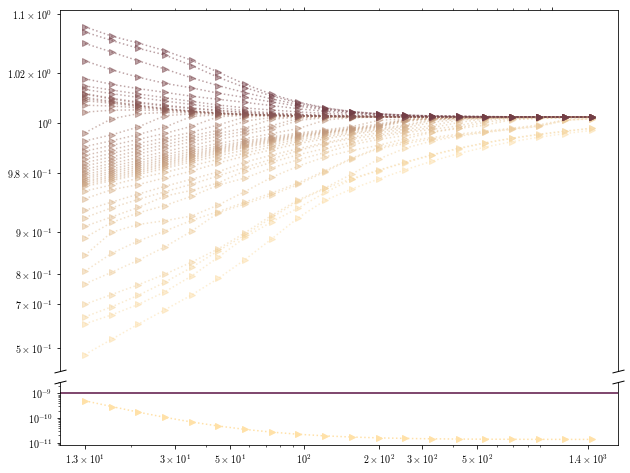

In [1779]:
# P_a^-1 A - base
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 1, height_ratios=[85, 15], hspace=0.05, figure=fig)

# Create two axes
ax = fig.add_subplot(gs[0]), fig.add_subplot(gs[1])

fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# Select indices to sample from (nm is large)
Base_Range  = np.unique(np.logspace(0,np.log10(nm), 40).astype(int))
Index_Range = np.unique(np.sort(np.r_[nm - np.unique(np.logspace(0,np.log10(nm), 10).astype(int)), Base_Range]))
#Index_Range = np.arange(1,nm, 20)

# –––––––– Plotting –––––––– #
kk=1
for k in Index_Range:
    ax[0].plot(Σ, Prec_Spectrums_P_a[:,k], linestyle=':', marker='>', alpha=0.5, color = colorFader('#ffe1a8','#723d46',kk/Index_Range.size) );
    kk +=1

# The second panel contains the smallest eigenvalues
ax[1].plot(Σ, Prec_Spectrums_P_a[:,0], linestyle=':', marker='>', alpha=1, color = colorFader('#ffe1a8','#723d46',0/Index_Range.size) );
ax[1].axhline(y = λ, color='xkcd:plum', linestyle='-')        # Add line at λ
ax[1].set_ylim(8e-12, 3e-9)

# Set scales
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('function', functions=(transform, inverse_transform))
#ax[0].set_yscale('log')
ax[1].set_yscale('log')


# –––––––– Ticks –––––––– #
# Add more ticks in x-axis — Second panel
ax_base = [1,1,1, 2,2,2,2, 3]
ax_val  = [ 1.3, 3, 5, 1, 2,3,5, 1.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_xticks(ax_loc, ax_lbl, fontname='CMR10')

# Add more ticks in y-axis — First panel
ax_base = [-1,-1,-1,-1, -1,   -1, 0,    0,  0]
ax_val  = [ 5, 7, 8, 9,  1,  9.8, 1, 1.02, 1.1]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[0].set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis — Second panel
ax_base = [-11,-10,-9]
ax_val  = [1,1,1]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_yticks(ax_loc, ax_lbl, fontname='CMR10');


# –––––––– Decorators –––––––– #
# hide the spines between ax and ax2
ax[0].spines.bottom.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[0].xaxis.tick_top()
ax[0].tick_params(labeltop=False)  # don't put tick labels at the top
ax[1].xaxis.tick_bottom()

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)

# –––––––– Store –––––––– #
fig.savefig('Eigs_M_Diag_a_Sigma_Base.pdf', bbox_inches='tight', pad_inches=0)

with open('Eigs_M_Diag_a_Sigma_Base.pickle', 'wb') as file:
    pl.dump(fig, file)

plt.show()

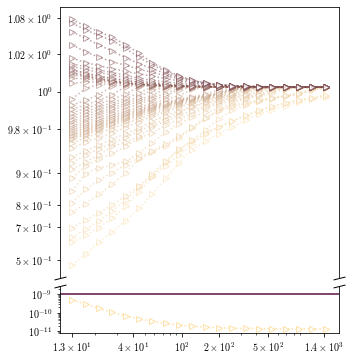

In [1937]:
# P_a^-1 A
fig = plt.figure(figsize=(5, 6))
gs = GridSpec(2, 1, height_ratios=[85, 15], hspace=0.05, figure=fig)

# Create two axes
ax = fig.add_subplot(gs[0]), fig.add_subplot(gs[1])

fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# Select indices to sample from (nm is large)
Base_Range  = np.unique(np.logspace(0,np.log10(nm), 40).astype(int))
Index_Range = np.unique(np.sort(np.r_[nm - np.unique(np.logspace(0,np.log10(nm), 10).astype(int)), Base_Range]))
#Index_Range = np.arange(1,nm, 20)

# –––––––– Plotting –––––––– #
kk=1
for k in Index_Range:
    ax[0].plot(Σ, Prec_Spectrums_P_a[:,k], linestyle=':', marker='>', alpha=0.5, 
               color = colorFader('#ffe1a8','#723d46',kk/Index_Range.size), markerfacecolor='white' );
    kk +=1

# The second panel contains the smallest eigenvalues
ax[1].plot(Σ, Prec_Spectrums_P_a[:,0], linestyle=':', marker='>', alpha=1, color = colorFader('#ffe1a8','#723d46',0), markerfacecolor='white' );
ax[1].axhline(y = λ, color='xkcd:plum', linestyle='-')        # Add line at λ
ax[1].set_ylim(8e-12, 3e-9)

# Set scales
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('function', functions=(transform, inverse_transform))
#ax[0].set_yscale('log')
ax[1].set_yscale('log')


# –––––––– Ticks –––––––– #
# Add more ticks in x-axis — Second panel
ax_base = [1,1, 2,2,2, 3]
ax_val  = [ 1.3, 4,  1, 2,5, 1.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_xticks(ax_loc, ax_lbl, fontname='CMR10')

# Add more ticks in y-axis — First panel
ax_base = [-1,-1,-1,-1, -1,   -1, 0,    0,  0]
ax_val  = [ 5, 7, 8, 9,  1,  9.8, 1, 1.02, 1.08]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[0].set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis — Second panel
ax_base = [-11,-10,-9]
ax_val  = [1,1,1]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_yticks(ax_loc, ax_lbl, fontname='CMR10');


# –––––––– Decorators –––––––– #
# hide the spines between ax and ax2
ax[0].tick_params(axis="x", which="both", length=0)
ax[0].xaxis.set_ticks([])
ax[0].spines['bottom'].set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].xaxis.tick_bottom()

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)

# –––––––– Store –––––––– #
fig.savefig('Eigs_M_Diag_a_Sigma.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

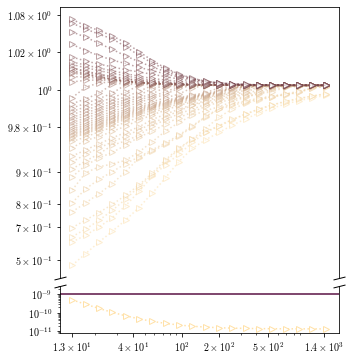

In [1938]:
# P_b^-1 A
fig = plt.figure(figsize=(5, 6))
gs = GridSpec(2, 1, height_ratios=[85, 15], hspace=0.05, figure=fig)

# Create two axes
ax = fig.add_subplot(gs[0]), fig.add_subplot(gs[1])

fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# Select indices to sample from (nm is large)
Base_Range  = np.unique(np.logspace(0,np.log10(nm), 40).astype(int))
Index_Range = np.unique(np.sort(np.r_[nm - np.unique(np.logspace(0,np.log10(nm), 10).astype(int)), Base_Range]))
#Index_Range = np.arange(1,nm, 20)

# –––––––– Plotting –––––––– #
kk=1
for k in Index_Range:
    ax[0].plot(Σ, Prec_Spectrums_P_b[:,k], linestyle=':', marker='>', alpha=0.5, 
               color = colorFader('#ffe1a8','#723d46',kk/Index_Range.size), markerfacecolor='white' );
    kk +=1

# The second panel contains the smallest eigenvalues
ax[1].plot(Σ, Prec_Spectrums_P_b[:,0], linestyle=':', marker='>', alpha=1, color = colorFader('#ffe1a8','#723d46',0), markerfacecolor='white' );
ax[1].axhline(y = λ, color='xkcd:plum', linestyle='-')        # Add line at λ
#ax[0].set_ylim(0.5, 1.1)
ax[1].set_ylim(8e-12, 3e-9)

# Set scales
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('function', functions=(transform, inverse_transform))
#ax[0].set_yscale('log')
ax[1].set_yscale('log')


# –––––––– Ticks –––––––– #
# Add more ticks in x-axis — Second panel
ax_base = [1,1, 2,2,2, 3]
ax_val  = [ 1.3, 4,  1, 2,5, 1.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_xticks(ax_loc, ax_lbl, fontname='CMR10')

# Add more ticks in y-axis — First panel
ax_base = [-1,-1,-1,-1, -1,   -1, 0,    0,  0]
ax_val  = [ 5, 7, 8, 9,  1,  9.8, 1, 1.02, 1.08]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[0].set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis — Second panel
ax_base = [-11,-10,-9]
ax_val  = [1,1,1]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_yticks(ax_loc, ax_lbl, fontname='CMR10');


# –––––––– Decorators –––––––– #
# hide the spines between ax[0] and ax[1]
ax[0].tick_params(axis="x", which="both", length=0)
ax[0].xaxis.set_ticks([])
ax[0].spines['bottom'].set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].xaxis.tick_bottom()

# hide the spines between ax[0] and ax[1]
#ax[0].tick_params(labelleft=False, left=False)
#ax[1].tick_params(labelleft=False, left=False)

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)

# –––––––– Store –––––––– #
fig.savefig('Eigs_M_Diag_b_Sigma.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

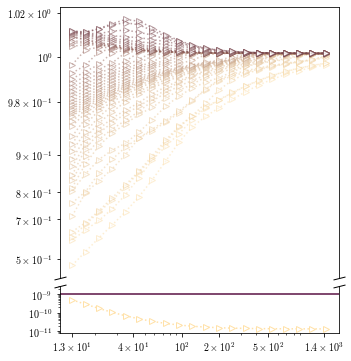

In [1939]:
# P_c^-1 A
fig = plt.figure(figsize=(5, 6))
gs = GridSpec(2, 1, height_ratios=[85, 15], hspace=0.05, figure=fig)

# Create two axes
ax = fig.add_subplot(gs[0]), fig.add_subplot(gs[1])

fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# Select indices to sample from (nm is large)
Base_Range  = np.unique(np.logspace(0,np.log10(nm), 40).astype(int))
Index_Range = np.unique(np.sort(np.r_[nm - np.unique(np.logspace(0,np.log10(nm), 10).astype(int)), Base_Range]))
#Index_Range = np.arange(1,nm, 20)

# –––––––– Plotting –––––––– #
kk=1
for k in Index_Range:
    ax[0].plot(Σ, Prec_Spectrums_P_c[:,k], linestyle=':', marker='>', alpha=0.5, 
               color = colorFader('#ffe1a8','#723d46',kk/Index_Range.size), markerfacecolor='white' );
    kk +=1

# The second panel contains the smallest eigenvalues
ax[1].plot(Σ, Prec_Spectrums_P_c[:,0], linestyle=':', marker='>', alpha=1, color = colorFader('#ffe1a8','#723d46',0), markerfacecolor='white' );
ax[1].axhline(y = λ, color='xkcd:plum', linestyle='-')        # Add line at λ
#ax[0].set_ylim(0.5, 1.1)
ax[1].set_ylim(8e-12, 3e-9)

# Set scales
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('function', functions=(transform, inverse_transform))
#ax[0].set_yscale('log')
ax[1].set_yscale('log')


# –––––––– Ticks –––––––– #
# Add more ticks in x-axis — Second panel
ax_base = [1,1, 2,2,2, 3]
ax_val  = [ 1.3, 4,  1, 2,5, 1.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_xticks(ax_loc, ax_lbl, fontname='CMR10')

# Add more ticks in y-axis — First panel
ax_base = [-1,-1,-1,-1, -1,   -1, 0,    0,  0]
ax_val  = [ 5, 7, 8, 9,  1,  9.8, 1, 1.02, 1.08]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[0].set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis — Second panel
ax_base = [-11,-10,-9]
ax_val  = [1,1,1]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_yticks(ax_loc, ax_lbl, fontname='CMR10');


# –––––––– Decorators –––––––– #
# hide the spines between ax[0] and ax[1]
ax[0].tick_params(axis="x", which="both", length=0)
ax[0].xaxis.set_ticks([])
ax[0].spines['bottom'].set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].xaxis.tick_bottom()

# hide the spines between ax[0] and ax[1]
#ax[0].tick_params(labelleft=False, left=False)
#ax[1].tick_params(labelleft=False, left=False)

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)

# –––––––– Store –––––––– #
fig.savefig('Eigs_M_Diag_c_Sigma.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

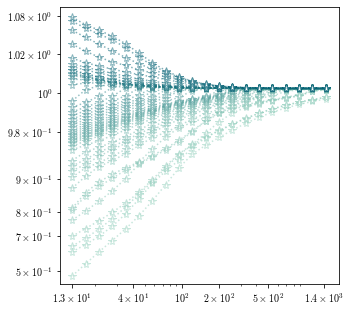

In [1943]:
# π[D_a^-1 A]
fig, ax = plt.subplots(1,1, facecolor='w', figsize=(5,6*0.85))

Base_Range  = np.unique(np.logspace(0,np.log10(nm), 40).astype(int))[:-1]
Index_Range = np.unique(np.sort(np.r_[(nm-1) - np.unique(np.logspace(0,np.log10(nm), 10).astype(int)), Base_Range]))

# –––––––– Plotting –––––––– #
kk=1
for k in Index_Range:
    plt.plot(Σ, Prec_Spectrums_D_a[:,k], linestyle=':', marker='*', alpha=0.5, markersize=8, 
             color = colorFader('#94d2bd','#005f73',kk/Index_Range.size), markerfacecolor='white' );
    kk +=1

    
# Set scales
ax.set_xscale('log')
ax.set_yscale('function', functions=(transform, inverse_transform))
#ax.set_yscale('log')
ax.set_ylim(0.4, 1.1)

# –––––––– Ticks –––––––– #
# Add more ticks in x-axis
ax_base = [1,1, 2,2,2, 3]
ax_val  = [ 1.3, 4,  1, 2,5, 1.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax.set_xticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis — First panel
ax_base = [-1,-1,-1,-1,   -1, 0,    0,  0]
ax_val  = [ 5, 7, 8, 9,  9.8, 1, 1.02, 1.08]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax.set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# –––––––– Store –––––––– #
fig.savefig('Eigs_M_Proj_a_Sigma.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

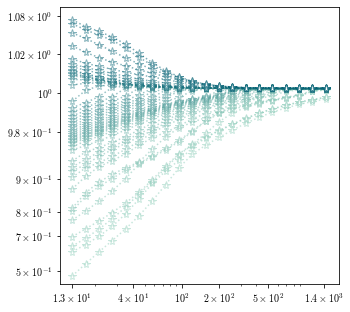

In [1944]:
# π[D_b^-1 A]
fig, ax = plt.subplots(1,1, facecolor='w', figsize=(5,6*0.85))

Base_Range  = np.unique(np.logspace(0,np.log10(nm), 40).astype(int))[:-1]
Index_Range = np.unique(np.sort(np.r_[(nm-1) - np.unique(np.logspace(0,np.log10(nm), 10).astype(int)), Base_Range]))

# –––––––– Plotting –––––––– #
kk=1
for k in Index_Range:
    plt.plot(Σ, Prec_Spectrums_D_b[:,k], linestyle=':', marker='*', alpha=0.5, markersize=8, 
             color = colorFader('#94d2bd','#005f73',kk/Index_Range.size), markerfacecolor='white' );
    kk +=1

    
# Set scales
ax.set_xscale('log')
ax.set_yscale('function', functions=(transform, inverse_transform))
#ax.set_yscale('log')
ax.set_ylim(0.4, 1.1)

# –––––––– Ticks –––––––– #
# Add more ticks in x-axis
ax_base = [1,1, 2,2,2, 3]
ax_val  = [ 1.3, 4,  1, 2,5, 1.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax.set_xticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis — First panel
ax_base = [-1,-1,-1,-1,   -1, 0,    0,  0]
ax_val  = [ 5, 7, 8, 9,  9.8, 1, 1.02, 1.08]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax.set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# –––––––– Store –––––––– #
fig.savefig('Eigs_M_Proj_b_Sigma.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

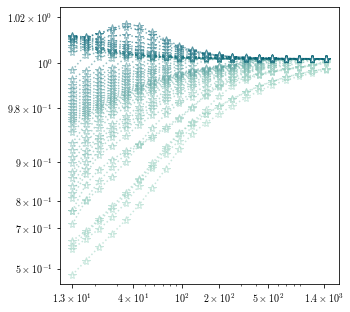

In [1945]:
# π[D_c^-1 A]
fig, ax = plt.subplots(1,1, facecolor='w', figsize=(5,6*0.85))

Base_Range  = np.unique(np.logspace(0,np.log10(nm), 40).astype(int))[:-1]
Index_Range = np.unique(np.sort(np.r_[(nm-1) - np.unique(np.logspace(0,np.log10(nm), 10).astype(int)), Base_Range]))

# –––––––– Plotting –––––––– #
kk=1
for k in Index_Range:
    plt.plot(Σ, Prec_Spectrums_D_c[:,k], linestyle=':', marker='*', alpha=0.5, markersize=8, 
             color = colorFader('#94d2bd','#005f73',kk/Index_Range.size), markerfacecolor='white' );
    kk +=1

    
# Set scales
ax.set_xscale('log')
ax.set_yscale('function', functions=(transform, inverse_transform))
#ax.set_yscale('log')
ax.set_ylim(0.4, 1.03)

# –––––––– Ticks –––––––– #
# Add more ticks in x-axis
ax_base = [1,1, 2,2,2, 3]
ax_val  = [ 1.3, 4,  1, 2,5, 1.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax.set_xticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis — First panel
ax_base = [-1,-1,-1,-1,   -1, 0,    0]
ax_val  = [ 5, 7, 8, 9,  9.8, 1, 1.02]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax.set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# –––––––– Store –––––––– #
fig.savefig('Eigs_M_Proj_c_Sigma.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

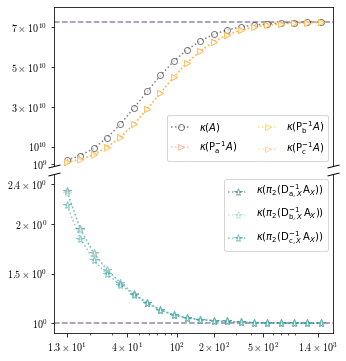

In [2042]:
# κ
fig = plt.figure(figsize=(5, 6))
gs = GridSpec(2, 1, height_ratios=[50, 50], hspace=0.05, figure=fig)

# Create two axes
ax = fig.add_subplot(gs[0]), fig.add_subplot(gs[1])

# –––––––– Plotting –––––––– #
# First panel
ax[0].axhline(y= μ*nm/λ, color='#9684A1', linestyle='--')
ax[0].plot(Σ, Exact_Spectrums[:,-1] / λ, linestyle=':', marker='o', alpha=0.5, 
           color = 'black', markerfacecolor='white', label='$\kappa(A)$')
ax[0].plot(Σ, Prec_Spectrums_P_a[:,-1] / Prec_Spectrums_P_a[:,0], linestyle=':', marker='>', alpha=0.5, 
           color='#FF7F50', markerfacecolor='white', label='$\kappa(\mathsf{P}_{\mathsf{a}}^{-1}A)$')
ax[0].plot(Σ, Prec_Spectrums_P_b[:,-1] / Prec_Spectrums_P_b[:,0], linestyle=':', marker='>', alpha=0.5, 
           color='#FFBF00', markerfacecolor='white', label='$\kappa(\mathsf{P}_{\mathsf{b}}^{-1}A)$')
ax[0].plot(Σ, Prec_Spectrums_P_c[:,-1] / Prec_Spectrums_P_c[:,0], linestyle=':', marker='>', alpha=0.5, 
           color='#FEBA4F', markerfacecolor='white', label='$\kappa(\mathsf{P}_{\mathsf{c}}^{-1}A)$')
    
## Present legend
ax[0].legend(loc='lower right', ncols = 2)


# Second panel
ax[1].axhline(y= 1.0, color='#9684A1', linestyle='--')
ax[1].plot(Σ, Prec_Spectrums_D_a[:,-1] / Prec_Spectrums_D_a[:,0], linestyle=':', marker='*', alpha=0.5, markersize=8, 
            color='#005f73', markerfacecolor='white', label='$\kappa( \pi_2 ( \mathsf{D}_{\mathsf{a},X}^{-1} \, \mathsf{A}_{X}) )$')
ax[1].plot(Σ, Prec_Spectrums_D_b[:,-1] / Prec_Spectrums_D_b[:,0], linestyle=':', marker='*', alpha=0.5, markersize=8, 
            color='#94d2bd', markerfacecolor='white', label='$\kappa( \pi_2 ( \mathsf{D}_{\mathsf{b},X}^{-1} \, \mathsf{A}_{X}) )$')
ax[1].plot(Σ, Prec_Spectrums_D_c[:,-1] / Prec_Spectrums_D_c[:,0], linestyle=':', marker='*', alpha=0.5, markersize=8, 
            color='#0a9396', markerfacecolor='white', label='$\kappa( \pi_2 ( \mathsf{D}_{\mathsf{c},X}^{-1} \, \mathsf{A}_{X}) )$')

## Present legend
ax[1].legend(loc='upper right', ncols = 1)

# The second panel contains the smallest eigenvalues
#ax[1].plot(Σ, Prec_Spectrums_P_c[:,0], linestyle=':', marker='>', alpha=1, color = colorFader('#ffe1a8','#723d46',0), markerfacecolor='white' );
#ax[1].axhline(y = λ, color='xkcd:plum', linestyle='-')        # Add line at λ
ax[0].set_ylim(1e+8, 8e+10)
ax[1].set_ylim(0.9, 2.5)

# Set scales
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#ax[0].set_yscale('function', functions=(transform, inverse_transform))
#ax[0].set_yscale('log')
#ax[1].set_yscale('log')
#ax[1].set_yscale('function', functions=(transform, inverse_transform))


# –––––––– Ticks –––––––– #
# Add more ticks in x-axis — Second panel
ax_base = [   1, 1 , 2,2,2, 3]
ax_val  = [ 1.3, 4,  1,2,5, 1.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_xticks(ax_loc, ax_lbl, fontname='CMR10')

# Add more ticks in y-axis — First panel
ax_base = [9, 10, 10, 10, 10]
ax_val  = [1,  1,  3, 5, 7]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[0].set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis — Second panel
ax_base = [0,0,0,0]
ax_val  = [1,1.5,2,2.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_yticks(ax_loc, ax_lbl, fontname='CMR10');


# –––––––– Decorators –––––––– #
# hide the spines between ax[0] and ax[1]
ax[0].tick_params(axis="x", which="both", length=0)
ax[0].xaxis.set_ticks([])
ax[0].spines['bottom'].set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].xaxis.tick_bottom()

# hide the spines between ax[0] and ax[1]
#ax[0].tick_params(labelleft=False, left=False)
#ax[1].tick_params(labelleft=False, left=False)

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)

# –––––––– Store –––––––– #
fig.savefig('Condition_Sigma_All.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

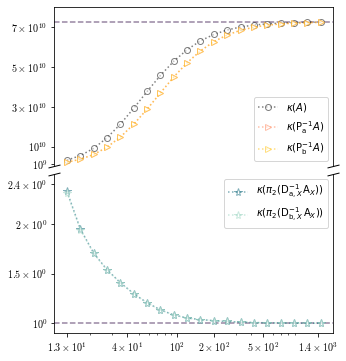

In [2041]:
# κ
fig = plt.figure(figsize=(5, 6))
gs = GridSpec(2, 1, height_ratios=[50, 50], hspace=0.05, figure=fig)

# Create two axes
ax = fig.add_subplot(gs[0]), fig.add_subplot(gs[1])

# –––––––– Plotting –––––––– #
# First panel
ax[0].axhline(y= μ*nm/λ, color='#9684A1', linestyle='--')
ax[0].plot(Σ, Exact_Spectrums[:,-1] / λ, linestyle=':', marker='o', alpha=0.5, 
           color = 'black', markerfacecolor='white', label='$\kappa(A)$')
ax[0].plot(Σ, Prec_Spectrums_P_a[:,-1] / Prec_Spectrums_P_a[:,0], linestyle=':', marker='>', alpha=0.5, 
           color='#FF7F50', markerfacecolor='white', label='$\kappa(\mathsf{P}_{\mathsf{a}}^{-1}A)$')
ax[0].plot(Σ, Prec_Spectrums_P_b[:,-1] / Prec_Spectrums_P_b[:,0], linestyle=':', marker='>', alpha=0.5, 
           color='#FFBF00', markerfacecolor='white', label='$\kappa(\mathsf{P}_{\mathsf{b}}^{-1}A)$')
'''ax[0].plot(Σ, Prec_Spectrums_P_c[:,-1] / Prec_Spectrums_P_c[:,0], linestyle=':', marker='>', alpha=0.5, 
           color='#FEBA4F', markerfacecolor='white', label='$\kappa(\mathsf{P}_{\mathsf{c}}^{-1}A)$')'''
    
## Present legend
ax[0].legend(loc='lower right', ncols = 1)


# Second panel
ax[1].axhline(y= 1.0, color='#9684A1', linestyle='--')
ax[1].plot(Σ, Prec_Spectrums_D_a[:,-1] / Prec_Spectrums_D_a[:,0], linestyle=':', marker='*', alpha=0.5, markersize=8, 
            color='#005f73', markerfacecolor='white', label='$\kappa( \pi_2 ( \mathsf{D}_{\mathsf{a},X}^{-1} \, \mathsf{A}_{X}) )$')
ax[1].plot(Σ, Prec_Spectrums_D_b[:,-1] / Prec_Spectrums_D_b[:,0], linestyle=':', marker='*', alpha=0.5, markersize=8, 
            color='#94d2bd', markerfacecolor='white', label='$\kappa( \pi_2 ( \mathsf{D}_{\mathsf{b},X}^{-1} \, \mathsf{A}_{X}) )$')
'''ax[1].plot(Σ, Prec_Spectrums_D_c[:,-1] / Prec_Spectrums_D_c[:,0], linestyle=':', marker='*', alpha=0.5, markersize=8, 
            color='#0a9396', markerfacecolor='white', label='$\kappa( \pi_2 ( \mathsf{D}_{\mathsf{c},X}^{-1} \, \mathsf{A}_{X}) )$')'''

## Present legend
ax[1].legend(loc='upper right', ncols = 1)

# The second panel contains the smallest eigenvalues
#ax[1].plot(Σ, Prec_Spectrums_P_c[:,0], linestyle=':', marker='>', alpha=1, color = colorFader('#ffe1a8','#723d46',0), markerfacecolor='white' );
#ax[1].axhline(y = λ, color='xkcd:plum', linestyle='-')        # Add line at λ
ax[0].set_ylim(1e+8, 8e+10)
ax[1].set_ylim(0.9, 2.5)

# Set scales
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#ax[0].set_yscale('function', functions=(transform, inverse_transform))
#ax[0].set_yscale('log')
#ax[1].set_yscale('log')
#ax[1].set_yscale('function', functions=(transform, inverse_transform))


# –––––––– Ticks –––––––– #
# Add more ticks in x-axis — Second panel
ax_base = [   1, 1 , 2,2,2, 3]
ax_val  = [ 1.3, 4,  1,2,5, 1.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_xticks(ax_loc, ax_lbl, fontname='CMR10')

# Add more ticks in y-axis — First panel
ax_base = [9, 10, 10, 10, 10]
ax_val  = [1,  1,  3, 5, 7]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[0].set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis — Second panel
ax_base = [0,0,0,0]
ax_val  = [1,1.5,2,2.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_yticks(ax_loc, ax_lbl, fontname='CMR10');


# –––––––– Decorators –––––––– #
# hide the spines between ax[0] and ax[1]
ax[0].tick_params(axis="x", which="both", length=0)
ax[0].xaxis.set_ticks([])
ax[0].spines['bottom'].set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].xaxis.tick_bottom()

# hide the spines between ax[0] and ax[1]
#ax[0].tick_params(labelleft=False, left=False)
#ax[1].tick_params(labelleft=False, left=False)

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)

# –––––––– Store –––––––– #
fig.savefig('Condition_Sigma.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

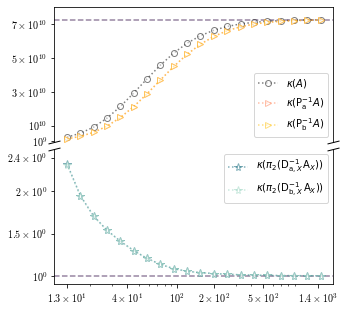

In [31]:
# κ
fig = plt.figure(figsize=(5, 6*0.85))
gs = GridSpec(2, 1, height_ratios=[50, 50], hspace=0.05, figure=fig)

# Create two axes
ax = fig.add_subplot(gs[0]), fig.add_subplot(gs[1])

# –––––––– Plotting –––––––– #
# First panel
ax[0].axhline(y= μ*nm/λ, color='#9684A1', linestyle='--')
ax[0].plot(Σ, Exact_Spectrums[:,-1] / λ, linestyle=':', marker='o', alpha=0.5, 
           color = 'black', markerfacecolor='white', label='$\kappa(A)$')
ax[0].plot(Σ, Prec_Spectrums_P_a[:,-1] / Prec_Spectrums_P_a[:,0], linestyle=':', marker='>', alpha=0.5, 
           color='#FF7F50', markerfacecolor='white', label='$\kappa(\mathsf{P}_{\mathsf{a}}^{-1}A)$')
ax[0].plot(Σ, Prec_Spectrums_P_b[:,-1] / Prec_Spectrums_P_b[:,0], linestyle=':', marker='>', alpha=0.5, 
           color='#FFBF00', markerfacecolor='white', label='$\kappa(\mathsf{P}_{\mathsf{b}}^{-1}A)$')
'''ax[0].plot(Σ, Prec_Spectrums_P_c[:,-1] / Prec_Spectrums_P_c[:,0], linestyle=':', marker='>', alpha=0.5, 
           color='#FEBA4F', markerfacecolor='white', label='$\kappa(\mathsf{P}_{\mathsf{c}}^{-1}A)$')'''
    
## Present legend
ax[0].legend(loc='lower right', ncols = 1)


# Second panel
ax[1].axhline(y= 1.0, color='#9684A1', linestyle='--')
ax[1].plot(Σ, Prec_Spectrums_D_a[:,-1] / Prec_Spectrums_D_a[:,0], linestyle=':', marker='*', alpha=0.5, markersize=8, 
            color='#005f73', markerfacecolor='white', label='$\kappa( \pi_2 ( \mathsf{D}_{\mathsf{a},X}^{-1} \, \mathsf{A}_{X}) )$')
ax[1].plot(Σ, Prec_Spectrums_D_b[:,-1] / Prec_Spectrums_D_b[:,0], linestyle=':', marker='*', alpha=0.5, markersize=8, 
            color='#94d2bd', markerfacecolor='white', label='$\kappa( \pi_2 ( \mathsf{D}_{\mathsf{b},X}^{-1} \, \mathsf{A}_{X}) )$')
'''ax[1].plot(Σ, Prec_Spectrums_D_c[:,-1] / Prec_Spectrums_D_c[:,0], linestyle=':', marker='*', alpha=0.5, markersize=8, 
            color='#0a9396', markerfacecolor='white', label='$\kappa( \pi_2 ( \mathsf{D}_{\mathsf{c},X}^{-1} \, \mathsf{A}_{X}) )$')'''

## Present legend
ax[1].legend(loc='upper right', ncols = 1)

# The second panel contains the smallest eigenvalues
#ax[1].plot(Σ, Prec_Spectrums_P_c[:,0], linestyle=':', marker='>', alpha=1, color = colorFader('#ffe1a8','#723d46',0), markerfacecolor='white' );
#ax[1].axhline(y = λ, color='xkcd:plum', linestyle='-')        # Add line at λ
ax[0].set_ylim(1e+8, 8e+10)
ax[1].set_ylim(0.9, 2.5)

# Set scales
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#ax[0].set_yscale('function', functions=(transform, inverse_transform))
#ax[0].set_yscale('log')
#ax[1].set_yscale('log')
#ax[1].set_yscale('function', functions=(transform, inverse_transform))


# –––––––– Ticks –––––––– #
# Add more ticks in x-axis — Second panel
ax_base = [   1, 1 , 2,2,2, 3]
ax_val  = [ 1.3, 4,  1,2,5, 1.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_xticks(ax_loc, ax_lbl, fontname='CMR10')

# Add more ticks in y-axis — First panel
ax_base = [9, 10, 10, 10, 10]
ax_val  = [1,  1,  3, 5, 7]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[0].set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis — Second panel
ax_base = [0,0,0,0]
ax_val  = [1,1.5,2,2.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_yticks(ax_loc, ax_lbl, fontname='CMR10');


# –––––––– Decorators –––––––– #
# hide the spines between ax[0] and ax[1]
ax[0].tick_params(axis="x", which="both", length=0)
ax[0].xaxis.set_ticks([])
ax[0].spines['bottom'].set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].xaxis.tick_bottom()

# hide the spines between ax[0] and ax[1]
#ax[0].tick_params(labelleft=False, left=False)
#ax[1].tick_params(labelleft=False, left=False)

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)

# –––––––– Store –––––––– #
fig.savefig('Condition_Sigma_b.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

Let's rather store the data we used for the plots intead of the plots themselves:

In [2049]:
Spectrums_Sigma = {
    'λ': λ,    'μ':μ,    'Σ': Σ,
    'Exact': Exact_Spectrums,
    'Diagonal':
    {
        'a':Prec_Spectrums_P_a, 'b':Prec_Spectrums_P_b, 'c':Prec_Spectrums_P_c
    },
    'Projection':
    {
        'a':Prec_Spectrums_D_a, 'b':Prec_Spectrums_D_b, 'c':Prec_Spectrums_D_c
    },
    'Particular': [Exact_Spectrum, Pₐ_Spectrum, Pᵦ_Spectrum, Pᵪ_Spectrum, Dₐ_Spectrum, Dᵦ_Spectrum, Dᵪ_Spectrum]
}

In [2057]:
with open('Spectrums.pkl', 'wb') as f: pl.dump(Spectrums_Sigma, f)

---

Load with:

In [2063]:
#with open("Spectrums.pkl", "rb") as input_file:    Spectrums_Sigma = pl.load(input_file).values()

In [40]:
import pickle as pl
with open("Spectrums.pkl", "rb") as input_file:    Spectrums_Sigma = pl.load(input_file)

In [41]:
abs(Spectrums_Sigma['Exact'][:,1] - Spectrums_Sigma['Exact'][:,-1])

array([ 3.13062678,  5.41120156,  9.04389393, 14.29784009, 21.07189034,
       28.84717749, 36.75273553, 43.74282335, 48.45876298, 49.33304752,
       45.53439325, 37.95177658, 28.85420238, 20.39537854, 13.6774088 ,
        8.85102319,  5.59645408,  3.4869729 ,  2.15278754,  1.32157822])

In [42]:
μ = Spectrums_Sigma['μ']
λ = Spectrums_Sigma['λ']
nm = Spectrums_Sigma['Exact'].shape[1]
Σ = Spectrums_Sigma['Σ']

In [43]:
Exact_Spectrums = Spectrums_Sigma['Exact']
Prec_Spectrums_P_a, Prec_Spectrums_P_b, Prec_Spectrums_P_c = Spectrums_Sigma['Diagonal']['a'], Spectrums_Sigma['Diagonal']['b'], Spectrums_Sigma['Diagonal']['c']
Prec_Spectrums_D_a, Prec_Spectrums_D_b, Prec_Spectrums_D_c = Spectrums_Sigma['Projection']['a'], Spectrums_Sigma['Projection']['b'], Spectrums_Sigma['Projection']['c']

In [44]:
Σ

array([  13.        ,   16.66625756,   21.36647239,   27.39224093,
         35.11739557,   45.02119689,   57.71806639,   73.99570464,
         94.86395938,  121.61747541,  155.91601301,  199.88741774,
        256.2596298 ,  328.52992252,  421.18186963,  539.96350149,
        692.24390688,  887.47040363, 1137.75464037, 1458.62399059])

In [45]:
np.ptp(Prec_Spectrums_P_a[7,1:])

0.1201458130200278

In [46]:
np.ptp(Prec_Spectrums_P_a[:,1:], 1)

array([0.61399211, 0.5171932 , 0.43569361, 0.36496376, 0.29934477,
       0.23435546, 0.17319047, 0.12014581, 0.07794126, 0.05092213,
       0.0365314 , 0.02624978, 0.01822883, 0.01218532, 0.0078948 ,
       0.00500161, 0.00312153, 0.00192947, 0.00118542, 0.00072556])

In [47]:
λ/(λ + μ*(nm-1))

1.3777900247812375e-11

In [48]:
abs(Prec_Spectrums_P_a[:,1:] - Prec_Spectrums_D_a[:,]).max()

3.601109410666936e-10

In [49]:
abs(Spectrums_Sigma['Particular'][1][1:] - Spectrums_Sigma['Particular'][4]).max()

2.3543056393293682e-11

In [62]:
((Spectrums_Sigma['Particular'][1][1:] - Spectrums_Sigma['Particular'][4])**2).sum()**0.5

3.1579527533686204e-11

In [39]:
pd.concat([pd.DataFrame([describe(diag_Pₐ)], columns=describe(diag_Pₐ)._fields), 
           pd.DataFrame([describe(diag_Pᵦ)], columns=describe(diag_Pᵦ)._fields),
           pd.DataFrame([describe(diag_Pᵪ)], columns=describe(diag_Pᵪ)._fields)], ignore_index=True)

,nobs,minmax,mean,variance,skewness,kurtosis
0,3630,"(0.04731597187027558, 5.757796114906498)",0.119966,0.065594,11.185004,173.768833
1,3630,"(0.04731566143103023, 5.754379785915313)",0.119958,0.065554,11.181280,173.649750
2,3630,"(0.04730324886950892, 5.6225228595984715)",0.119629,0.064011,11.037347,169.079703


In [59]:
Spectrums_Sigma['Particular'][1][1] - λ/(λ + μ*0.04731597187027558) < Spectrums_Sigma['Particular'][4][0], Spectrums_Sigma['Particular'][1][1] > Spectrums_Sigma['Particular'][4][0]

(True, True)

In [67]:
λ/(λ + μ*0.04731597187027558)

1.05672450945016e-06

In [83]:
Spectrums_Sigma['Particular'][1][1] - Spectrums_Sigma['Particular'][4][0]

2.0933255129307327e-11

In [84]:
Spectrums_Sigma['Particular'][2][1] - λ/(λ + μ*0.04731597187027558) < Spectrums_Sigma['Particular'][5][0], Spectrums_Sigma['Particular'][2][1] > Spectrums_Sigma['Particular'][5][0]

(True, True)

In [86]:
Spectrums_Sigma['Particular'][2][1] - Spectrums_Sigma['Particular'][5][0], abs(Spectrums_Sigma['Particular'][2][1:] - Spectrums_Sigma['Particular'][5]).max()

(2.0947243939417604e-11, 2.3508417434925377e-11)

---